In [1]:
import os
import sys
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from pprint import pprint
from IPython.display import display
from functools import reduce
import pandas as pd
import pathlib
from sklearn.metrics import classification_report
import numpy as np
import json
from pprint import pprint

current_path = os.path.dirname(os.path.abspath("./"))
print(current_path)
sys.path.append(current_path)

# Local helper modules
import helper
from helper import read_json, matchMLKeyWords
import commonpath
from commonpath import FIG_DIR, OUTPUT_DIR, PROJ_REPOS_CHUNKS_QA_DIR, PROJ_REPOS_PATH
from collections import defaultdict

# !pip install rapidfuzz
from rapidfuzz import fuzz, utils
import re
import semver
import packaging

/home/jupyter-lihao/mlbindings/src
import facets_overview error!


In [2]:
rq3_data_dir = commonpath.DATA_DIR
rq3_versions = helper.readCSV(rq3_data_dir / "labelled_rq3_pop_ml_bindings_versions.csv")
rq3_versions["Published Timestamp"] = helper.toDatetime(rq3_versions["Published Timestamp"])
versions_invalid_time_mask = rq3_versions["Published Timestamp"] == pd.Timestamp("1900-01-01 00:00:00")
print(f"removed {sum(versions_invalid_time_mask)} invalid timestamp for rq3 versions")
rq3_versions = rq3_versions[~versions_invalid_time_mask]
rq3_versions = rq3_versions.sort_values(["Project ID", "Published Timestamp"])

rq3_bindings = helper.readCSV(rq3_data_dir / "labelled_rq3_pop_ml_bindings.csv")
rq3_repos = helper.readCSV(rq3_data_dir / "labelled_rq3_pop_ml_repos.csv")
rq3_repo_tags = helper.readCSV(rq3_data_dir / "rq3_pop_ml_repos_tags.csv")
rq3_repo_tags["Tag Published Timestamp"] = helper.toDatetime(rq3_repo_tags["Tag Published Timestamp"])
# tags_invalid_time_mask = rq3_repo_tags["Tag Published Timestamp"] == pd.Timestamp("1900-01-01 00:00:00")
# print(f"removed {sum(tags_invalid_time_mask)} invalid timestamp for rq3 tags")
# rq3_repo_tags = rq3_repo_tags[~tags_invalid_time_mask]
rq3_repo_tags = rq3_repo_tags.sort_values(["Repository ID", "Tag Published Timestamp"])

display(rq3_repo_tags.head(5))
rq3_repo_tags = rq3_repo_tags[rq3_repo_tags["Repository ID"].isin(rq3_repos["ID"])]
print(len(rq3_repo_tags), len(rq3_repo_tags["Repository ID"].unique()))

# formating main package into `int`
rq3_repos["Main Package"] = rq3_repos["Main Package"].apply(lambda x: x if x == "repo" else str(x))
helper.printValueCountsPercentage(rq3_repos["Main Package"] == "repo")
rq3_bindings = rq3_bindings.merge(rq3_repos[["ID", "Main Package"]], left_on="Host Repo IDs", right_on="ID", suffixes=("", " Main Repo"))
# rq3_bindings.drop('ID_Repo', axis=1, inplace=True)
rq3_versions = rq3_versions.merge(rq3_bindings[["ID", "Main Package", "ID Main Repo"]], left_on="Project ID", right_on="ID", suffixes=("", "_Project"))
rq3_versions.drop('ID_Project', axis=1, inplace=True)
display(rq3_repos.head(5))
display(rq3_bindings.head(5))
display(rq3_versions.head(5))

removed 14 invalid timestamp for rq3 versions


,ID,Host Type,Repository Name with Owner,Repository ID,Tag Name,Tag git sha,Tag Published Timestamp,Tag Created Timestamp,Tag Updated Timestamp
20,391328,GitHub,eclipse/deeplearning4j,165170,deeplearning4j-parent-0.0.0.1,4562e31ffd1512e4dd76d601fecfe1cf774aa076,2014-02-22 08:19:27,2015-03-07 11:12:16 UTC,2015-03-07 11:12:16 UTC
73,82732612,GitHub,eclipse/deeplearning4j,165170,_old/deeplearning4j-parent-0.0.0.1,184a90815937abef8093689993b8bfd573d04401,2014-02-22 08:19:27,2019-09-08 21:07:41 UTC,2019-09-08 21:07:41 UTC
22,391331,GitHub,eclipse/deeplearning4j,165170,deeplearning4j-parent-0.0.0.3,77ae6a18b6b5c5fb7fe4ff8e1845c8a18065ea57,2014-02-22 18:03:19,2015-03-07 11:12:16 UTC,2015-03-07 11:12:16 UTC
75,82732620,GitHub,eclipse/deeplearning4j,165170,_old/deeplearning4j-parent-0.0.0.3,f2636bf758c8baae9e2b90e449a900653521a81d,2014-02-22 18:03:19,2019-09-08 21:07:43 UTC,2019-09-08 21:07:43 UTC
21,391329,GitHub,eclipse/deeplearning4j,165170,deeplearning4j-parent-0.0.0.2,2e25f527454e243be87f0693da75df0442909ba3,2014-02-22 18:50:12,2015-03-07 11:12:16 UTC,2015-03-07 11:12:16 UTC


3785 39
20 / 40 = 50.0% False
20 / 40 = 50.0% True


,Manual Inspection Notes,Has Bindings?,Main Package,ID,Host Type,Name with Owner,Description,Fork,Created Timestamp,Updated Timestamp,...,Dummy,SCM type,Pull requests enabled,Logo URL,Keywords,Name,Owner,Name Normalized,Name Normalized - No Space,Num of Platforms
0,NaN,True,353059,165170,GitHub,eclipse/deeplearning4j,"Eclipse Deeplearning4j, ND4J, DataVec and more...",False,2013-11-27 2:03:28,2019-11-23 01:10:35 UTC,...,NaN,git,NaN,NaN,"artificial-intelligence,clojure,deeplearning,d...",deeplearning4j,eclipse,deeplearning4j,deeplearning4j,2
1,NaN,True,2239255,168500,GitHub,Alluxio/alluxio,"Alluxio, data orchestration for analytics and ...",False,2012-12-21 17:43:46,2019-12-19 00:42:40 UTC,...,NaN,git,NaN,NaN,"alluxio,data-analysis,data-orchestration,hadoo...",alluxio,Alluxio,alluxio,alluxio,2
2,"NOTE: CRAN has the first release, but PyPI has...",True,repo,339654,GitHub,dmlc/xgboost,"Scalable, Portable and Distributed Gradient Bo...",False,2014-02-06 17:28:03,2019-12-23 15:48:51 UTC,...,NaN,git,NaN,NaN,"distributed-systems,gbdt,gbm,gbrt,machine-lear...",xgboost,dmlc,xgboost,xgboost,6
3,"NOTE: CRAN has the first release, but PyPI has...",True,334746,527263,GitHub,h2oai/h2o-3,Open Source Fast Scalable Machine Learning Pla...,False,2014-03-03 16:08:07,2019-12-17 05:32:33 UTC,...,NaN,git,NaN,NaN,"automatic,big-data,data-science,deep-learning,...",h2o-3,h2oai,h2o 3,h2o3,3
4,NaN,True,repo,573443,GitHub,apache/predictionio,"PredictionIO, a machine learning server for de...",False,2013-01-25 19:42:32,2019-12-19 01:58:57 UTC,...,NaN,git,NaN,NaN,"big-data,predictionio,scala",predictionio,apache,predictionio,predictionio,8


,Auto Aligned,Binding Type,Initial Aligned Version,Aligned Note,Manual Inspection Notes,Binding?,Related?,Official?,Main package?,ID,...,Repository Host Type,Repository Fork?,Repository Stars Count,Repository License,Repository Status,Repository Keywords,Binding Host Normalized,Binding Host Normalized - No Space,ID Main Repo,Main Package
0,main,NaN,NaN,NaN,NaN,True,True,True,True,353059,...,GitHub,False,11328.0,Apache-2.0,NaN,"artificial-intelligence,clojure,deeplearning,d...",NaN,NaN,165170,353059
1,Y,NaN,NaN,NaN,"one ecosystem, two bindings",True,True,True,NaN,3122840,...,GitHub,False,326.0,Apache-2.0,Unmaintained,"deeplearning,deeplearning4j,nd4j,sbt,scala,spark",deeplearning4j,deeplearning4j,165170,353059
2,N,NaN,NaN,look dep info in https://clojars.org/hswick/ju...,NaN,True,False,False,NaN,3581741,...,NaN,NaN,NaN,NaN,NaN,NaN,deeplearning4j,deeplearning4j,165170,353059
3,main,NaN,NaN,NaN,NaN,True,False,True,True,2239255,...,NaN,NaN,NaN,NaN,NaN,NaN,alluxio,alluxio,168500,2239255
4,N,NaN,NaN,NaN,official without link,True,False,False,NaN,2424129,...,NaN,NaN,NaN,NaN,NaN,NaN,alluxio,alluxio,168500,2239255


,Host Repo IDs,Project ID,Platform,Project Name,Number,Published Timestamp,Matched Tag,Matched Version,ID,Created Timestamp,Updated Timestamp,Main Package,ID Main Repo
0,845081,61313,Pypi,nltk,2.0b4,2009-07-15 09:32:16,0.0.0,2.0b4,168321,2015-01-21 00:41:45 UTC,2015-01-21 00:41:45 UTC,61313,845081
1,845081,61313,Pypi,nltk,2.0b5,2009-07-19 10:20:15,0.0.0,2.0b5,168318,2015-01-21 00:41:45 UTC,2015-01-21 00:41:45 UTC,61313,845081
2,845081,61313,Pypi,nltk,2.0b6,2009-09-25 10:31:59,0.0.0,2.0b6,168313,2015-01-21 00:41:45 UTC,2015-01-21 00:41:45 UTC,61313,845081
3,845081,61313,Pypi,nltk,2.0b7,2009-11-09 14:20:36,0.0.0,2.0b7,168310,2015-01-21 00:41:45 UTC,2015-01-21 00:41:45 UTC,61313,845081
4,845081,61313,Pypi,nltk,2.0b8,2010-03-10 20:30:23,0.0.0,2.0b8,168307,2015-01-21 00:41:45 UTC,2015-01-21 00:41:45 UTC,61313,845081


In [3]:
mask = np.logical_and(rq3_repo_tags["Repository ID"] == 852560, rq3_repo_tags["Tag Name"] == "3.03-rc1")
rq3_repo_tags.loc[mask, "Tag Published Timestamp"] = pd.Timestamp("2014-02-04 19:53:00")
rq3_repo_tags[mask]
# rq3_repo_tags.loc[rq3_repo_tags["Repository ID"] == 527263, "Main Package"] = "repo"
# remove 2708448 @tensorflow/tfjs since we use @tensorflow/tfjs-node
rq3_bindings = rq3_bindings[rq3_bindings["ID"] != 2708448]
rq3_versions = rq3_versions[rq3_versions["Project ID"] != 2708448]
# pd.Timestamp("2014-02-04 19:53:00")

In [4]:
rq3_bindings = helper.formatIDColumnsToStr(rq3_bindings)
rq3_repo_tags = helper.formatIDColumnsToStr(rq3_repo_tags)
rq3_repos = helper.formatIDColumnsToStr(rq3_repos)
rq3_versions = helper.formatIDColumnsToStr(rq3_versions)

In [5]:
print("using repo tags")
helper.printValueCountsPercentage(rq3_repos["Main Package"] == "repo")
print("main packages vs bindings")
helper.printValueCountsPercentage(rq3_bindings["Main Package"] == rq3_bindings["ID"])
# sum()

using repo tags
20 / 40 = 50.0% False
20 / 40 = 50.0% True
main packages vs bindings
134 / 154 = 87.01298701298701% False
20 / 154 = 12.987012987012985% True


In [6]:
pid_mapping = {}
def genID(df):
    mask1 = rq3_bindings["Host Repo IDs"] == df["Host Repo IDs"]
    mask2 = rq3_bindings["Platform"] == df["Platform"]
    mask = np.logical_and(mask1, mask2)
    if sum(mask) == 1:
        return df["ID"]
    
    # print(rq3_bindings[mask]["ID"].values.tolist())
    new_id = "+".join(rq3_bindings[mask]["ID"].sort_values().to_list())
    pid_mapping[df["ID"]] = new_id
    return new_id
    # print(new_id)
    # display(df[["Host Repo IDs", "Platform", "ID", "Name"]])
rq3_bindings["ID"] = rq3_bindings.apply(genID, axis=1)
helper.printPercentage(len(rq3_bindings["ID"].unique()), len(rq3_bindings), "unique platforms")
print(rq3_bindings.columns)
pid_mapping

137 / 154 = 88.96103896103897% unique platforms
Index(['Auto Aligned', 'Binding Type', 'Initial Aligned Version',
       'Aligned Note', 'Manual Inspection Notes', 'Binding?', 'Related?',
       'Official?', 'Main package?', 'ID', 'Host Repo IDs', 'Type', 'Platform',
       'Name', 'Repository URL', 'First Version Date', 'Versions Count',
       'Binding Host', 'Description', 'Repository Name with Owner',
       'Repository Description', 'Keywords', 'Licenses',
       'Dependent Projects Count', 'Status', 'Dependent Repositories Count',
       'Repository ID', 'Repository Host Type', 'Repository Fork?',
       'Repository Stars Count', 'Repository License', 'Repository Status',
       'Repository Keywords', 'Binding Host Normalized',
       'Binding Host Normalized - No Space', 'ID Main Repo', 'Main Package'],
      dtype='object')


{'353059': '3122840+353059',
 '3122840': '3122840+353059',
 '2301217': '2301217+2417372',
 '2417372': '2301217+2417372',
 '4100346': '4100346+4254235+4254237',
 '4254237': '4100346+4254235+4254237',
 '4254235': '4100346+4254235+4254237',
 '310941': '310941+310942',
 '310942': '310941+310942',
 '631591': '1018886+3498980+3498982+624343+631591',
 '624343': '1018886+3498980+3498982+624343+631591',
 '1018886': '1018886+3498980+3498982+624343+631591',
 '3498982': '1018886+3498980+3498982+624343+631591',
 '3498980': '1018886+3498980+3498982+624343+631591',
 '728265': '2456057+728265',
 '2456057': '2456057+728265',
 '2405186': '178575+2405186',
 '178575': '178575+2405186',
 '2335117': '2335117+2715706',
 '2715706': '2335117+2715706',
 '175941': '175941+3399973',
 '730115': '2710449+730115',
 '1134396': '1134396+72824',
 '72824': '1134396+72824',
 '2710449': '2710449+730115',
 '3399973': '175941+3399973',
 '1627986': '1627986+1929070',
 '1929070': '1627986+1929070',
 '3691610': '3691610+425684

In [7]:
def mapPIDColumn(df_col):
    return df_col.apply(lambda x: pid_mapping[x] if x in pid_mapping else x)

rq3_repos["Main Package"] = mapPIDColumn(rq3_repos["Main Package"])
rq3_bindings["Main Package"] = mapPIDColumn(rq3_bindings["Main Package"])
rq3_versions["Main Package"] = mapPIDColumn(rq3_versions["Main Package"])
rq3_versions["Project ID"] = mapPIDColumn(rq3_versions["Project ID"])
rq3_versions = rq3_versions.sort_values(["Project ID", "Published Timestamp"])

In [8]:
rq3_versions.sort_values(["Project ID", "Published Timestamp"])

,Host Repo IDs,Project ID,Platform,Project Name,Number,Published Timestamp,Matched Tag,Matched Version,ID,Created Timestamp,Updated Timestamp,Main Package,ID Main Repo
568,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp-AnyCPU,2.4.8.20140522,2014-05-23 03:26:20,2.4.8,NaN,2405925,2015-02-18 04:12:42 UTC,2015-02-18 04:12:42 UTC,repo,851991
569,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp-AnyCPU,2.4.8.20140523,2014-05-23 04:00:57,2.4.8,NaN,2405926,2015-02-18 04:12:42 UTC,2015-02-18 04:12:42 UTC,repo,851991
570,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp-AnyCPU,2.4.8.20140527,2014-05-27 12:32:55,2.4.8,NaN,2405927,2015-02-18 04:12:42 UTC,2015-02-18 04:12:42 UTC,repo,851991
571,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp-AnyCPU,2.4.8.20140529,2014-05-30 07:47:56,2.4.8,NaN,2405928,2015-02-18 04:12:42 UTC,2015-02-18 04:12:42 UTC,repo,851991
572,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp-AnyCPU,2.4.8.20140607,2014-06-08 02:12:48,2.4.8,NaN,2405929,2015-02-18 04:12:42 UTC,2015-02-18 04:12:42 UTC,repo,851991
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,852009,999771,Clojars,engagor/clj-vw,1.0.1,2015-10-05 07:40:48,0.0.0,NaN,3905030,2015-10-05 07:40:48 UTC,2015-10-05 07:40:48 UTC,repo,852009
1069,852009,999771,Clojars,engagor/clj-vw,1.1.0,2015-10-05 07:40:48,0.0.0,NaN,3905029,2015-10-05 07:40:48 UTC,2015-10-05 07:40:48 UTC,repo,852009
1070,852009,999771,Clojars,engagor/clj-vw,1.1.1,2015-10-05 07:40:48,0.0.0,NaN,3905028,2015-10-05 07:40:48 UTC,2015-10-05 07:40:48 UTC,repo,852009
1071,852009,999771,Clojars,engagor/clj-vw,1.1.2,2015-12-22 01:01:52,0.0.0,NaN,4529503,2015-12-22 01:01:52 UTC,2015-12-22 01:01:52 UTC,repo,852009


In [9]:
main_package_mask = rq3_bindings["Main Package"] == rq3_bindings["ID"]
helper.printValueCountsPercentage(rq3_bindings[~main_package_mask]["Official?"])
helper.printValueCountsPercentage(rq3_bindings[~main_package_mask]["Auto Aligned"])

97 / 133 = 72.93233082706767% False
36 / 133 = 27.06766917293233% True
92 / 133 = 69.17293233082707% N
41 / 133 = 30.82706766917293% Y


## Santy check
- Matched Version can be found?
- Matched Tag can be found?
- Remove the main package for calculation

In [10]:
helper.printValueCountsPercentage(rq3_repo_tags["Tag Name"].apply(lambda x: str(type(x))))
helper.printValueCountsPercentage(rq3_versions["Number"].apply(lambda x: str(type(x))))
helper.printValueCountsPercentage(rq3_versions["Matched Tag"].dropna().apply(lambda x: str(type(x))))
helper.printValueCountsPercentage(rq3_versions["Matched Version"].dropna().apply(lambda x: str(type(x))))

align_repo_tag_mask = rq3_versions["Main Package"] == "repo"
rq3_versions_align_tags = rq3_versions[align_repo_tag_mask]
rq3_versions_align_versions = rq3_versions[~align_repo_tag_mask]
# helper.printValueCountsPercentage(rq3_repo_tags["Tag Name"].apply(type))

3785 / 3785 = 100.0% <class 'str'>
3189 / 3189 = 100.0% <class 'str'>
2819 / 2819 = 100.0% <class 'str'>
2067 / 2067 = 100.0% <class 'str'>


In [11]:
def checkRepoTag(df):
    r_id, r_tag = df["ID Main Repo"], df["Matched Tag"]
    mask1 = rq3_repo_tags["Repository ID"] == r_id
    mask2 = rq3_repo_tags["Tag Name"] == r_tag
    return sum(np.logical_and(mask1, mask2))

matched_times = rq3_versions_align_tags.apply(checkRepoTag, axis=1)
helper.printValueCountsPercentage(matched_times)

# duplicated tags in tesseract, mlflow, and onnx, we can use the first one (earliest)
rq3_versions_align_tags[matched_times == 2]
display(rq3_versions_align_tags[matched_times == 2])

not_found = rq3_versions_align_tags[matched_times == 0]
# two tags from opencv and ncnn are not included in the dataset
# we can set them to 0.0.0 to exclude them
inspect = not_found[not_found["Matched Tag"] != "0.0.0"]
display(inspect)
future_release_vids = inspect["ID"]
rq3_versions.loc[rq3_versions["ID"].isin(future_release_vids), "Matched Tag"] = "0.0.0"
display(inspect)
rq3_versions[rq3_versions["ID"].isin(future_release_vids)]

1010 / 1189 = 84.94533221194281% 1
165 / 1189 = 13.877207737594619% 0
14 / 1189 = 1.1774600504625736% 2


,Host Repo IDs,Project ID,Platform,Project Name,Number,Published Timestamp,Matched Tag,Matched Version,ID,Created Timestamp,Updated Timestamp,Main Package,ID Main Repo
1524,852560,2188286,NuGet,tesseract.net,4.0.0.3,2017-07-27 08:24:18,4.00.00alpha,NaN,10115047,2017-07-27 09:19:06 UTC,2017-07-27 09:19:06 UTC,repo,852560
1525,852560,2188286,NuGet,tesseract.net,4.0.0.5,2017-08-01 06:41:01,4.00.00alpha,NaN,10154145,2017-08-01 07:18:56 UTC,2017-08-01 07:18:56 UTC,repo,852560
1526,852560,2188286,NuGet,tesseract.net,4.0.0.6,2017-08-17 10:59:22,4.00.00alpha,NaN,10295182,2017-08-17 11:18:59 UTC,2017-08-17 11:18:59 UTC,repo,852560
1527,852560,2188286,NuGet,tesseract.net,4.0.0.10,2018-01-24 11:41:25,4.00.00alpha,NaN,11862606,2018-01-24 12:20:17 UTC,2018-01-24 12:20:17 UTC,repo,852560
1528,852560,2188286,NuGet,tesseract.net,4.0.0.12,2018-01-24 12:07:20,4.00.00alpha,NaN,11862619,2018-01-24 12:20:41 UTC,2018-01-24 12:20:41 UTC,repo,852560
1530,852560,2188286,NuGet,tesseract.net,4.0.0.13,2018-02-02 05:04:10,4.00.00alpha,NaN,11923477,2018-02-02 05:19:31 UTC,2018-02-02 05:19:31 UTC,repo,852560
1531,852560,2188286,NuGet,tesseract.net,4.0.0.14,2018-05-15 08:12:56,4.00.00alpha,NaN,16827760,2018-11-29 06:18:07 UTC,2018-11-29 06:18:07 UTC,repo,852560
1532,852560,2188286,NuGet,tesseract.net,4.0.0.15,2018-06-21 11:33:54,4.00.00alpha,NaN,16827766,2018-11-29 06:18:07 UTC,2018-11-29 06:18:07 UTC,repo,852560
1533,852560,2188286,NuGet,tesseract.net,4.0.0.16,2018-07-31 10:11:27,4.00.00alpha,NaN,16827772,2018-11-29 06:18:07 UTC,2018-11-29 06:18:07 UTC,repo,852560
1534,852560,2188286,NuGet,tesseract.net,4.0.0.17,2019-02-08 05:40:36,4.00.00alpha,NaN,17836509,2019-02-08 06:18:15 UTC,2019-02-08 06:18:15 UTC,repo,852560


,Host Repo IDs,Project ID,Platform,Project Name,Number,Published Timestamp,Matched Tag,Matched Version,ID,Created Timestamp,Updated Timestamp,Main Package,ID Main Repo
2857,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp4.Windows,4.2.0.20191223,2019-12-23 04:22:46,4.2.0,NaN,23955350,2019-12-23 05:18:15 UTC,2019-12-23 05:18:15 UTC,repo,851991
2858,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp4.Windows,4.2.0.20200108,2020-01-08 01:40:22,4.2.0,NaN,24191568,2020-01-08 02:20:34 UTC,2020-01-08 02:20:34 UTC,repo,851991
1486,891695,1596765,CocoaPods,dlib,19,2016-08-02 11:53:39,NaN,19.0.0,6476981,2016-08-02 11:53:39 UTC,2016-08-02 11:53:39 UTC,repo,891695
1487,891695,1596765,CocoaPods,dlib,19.1,2016-09-21 12:05:14,NaN,19.1.0,6809829,2016-09-21 12:05:14 UTC,2016-09-21 12:05:14 UTC,repo,891695
1488,891695,1596765,CocoaPods,dlib,19.4,2018-10-22 18:07:48,NaN,19.4.0,16150426,2018-10-22 18:07:48 UTC,2018-10-22 18:07:48 UTC,repo,891695
2919,23744105,3624809,NuGet,OpenPoseDotNet,1.4.0.20190115,2019-01-15 15:51:00,1.4.0,NaN,17568111,2019-01-15 16:18:16 UTC,2019-01-15 16:18:16 UTC,repo,23744105
2920,23744105,3624809,NuGet,OpenPoseDotNet,1.4.0.20190117,2019-01-16 15:40:53,1.4.0,NaN,17591339,2019-01-16 16:18:16 UTC,2019-01-16 16:18:16 UTC,repo,23744105
3262,26463085,4776288,NuGet,NcnnDotNet,0.0.0.20200106,2020-01-12 15:03:25,20200106,NaN,24281959,2020-01-12 15:18:22 UTC,2020-01-12 15:18:22 UTC,repo,26463085


,Host Repo IDs,Project ID,Platform,Project Name,Number,Published Timestamp,Matched Tag,Matched Version,ID,Created Timestamp,Updated Timestamp,Main Package,ID Main Repo
2857,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp4.Windows,4.2.0.20191223,2019-12-23 04:22:46,4.2.0,NaN,23955350,2019-12-23 05:18:15 UTC,2019-12-23 05:18:15 UTC,repo,851991
2858,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp4.Windows,4.2.0.20200108,2020-01-08 01:40:22,4.2.0,NaN,24191568,2020-01-08 02:20:34 UTC,2020-01-08 02:20:34 UTC,repo,851991
1486,891695,1596765,CocoaPods,dlib,19,2016-08-02 11:53:39,NaN,19.0.0,6476981,2016-08-02 11:53:39 UTC,2016-08-02 11:53:39 UTC,repo,891695
1487,891695,1596765,CocoaPods,dlib,19.1,2016-09-21 12:05:14,NaN,19.1.0,6809829,2016-09-21 12:05:14 UTC,2016-09-21 12:05:14 UTC,repo,891695
1488,891695,1596765,CocoaPods,dlib,19.4,2018-10-22 18:07:48,NaN,19.4.0,16150426,2018-10-22 18:07:48 UTC,2018-10-22 18:07:48 UTC,repo,891695
2919,23744105,3624809,NuGet,OpenPoseDotNet,1.4.0.20190115,2019-01-15 15:51:00,1.4.0,NaN,17568111,2019-01-15 16:18:16 UTC,2019-01-15 16:18:16 UTC,repo,23744105
2920,23744105,3624809,NuGet,OpenPoseDotNet,1.4.0.20190117,2019-01-16 15:40:53,1.4.0,NaN,17591339,2019-01-16 16:18:16 UTC,2019-01-16 16:18:16 UTC,repo,23744105
3262,26463085,4776288,NuGet,NcnnDotNet,0.0.0.20200106,2020-01-12 15:03:25,20200106,NaN,24281959,2020-01-12 15:18:22 UTC,2020-01-12 15:18:22 UTC,repo,26463085


,Host Repo IDs,Project ID,Platform,Project Name,Number,Published Timestamp,Matched Tag,Matched Version,ID,Created Timestamp,Updated Timestamp,Main Package,ID Main Repo
2857,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp4.Windows,4.2.0.20191223,2019-12-23 04:22:46,0.0.0,NaN,23955350,2019-12-23 05:18:15 UTC,2019-12-23 05:18:15 UTC,repo,851991
2858,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp4.Windows,4.2.0.20200108,2020-01-08 01:40:22,0.0.0,NaN,24191568,2020-01-08 02:20:34 UTC,2020-01-08 02:20:34 UTC,repo,851991
1486,891695,1596765,CocoaPods,dlib,19,2016-08-02 11:53:39,0.0.0,19.0.0,6476981,2016-08-02 11:53:39 UTC,2016-08-02 11:53:39 UTC,repo,891695
1487,891695,1596765,CocoaPods,dlib,19.1,2016-09-21 12:05:14,0.0.0,19.1.0,6809829,2016-09-21 12:05:14 UTC,2016-09-21 12:05:14 UTC,repo,891695
1488,891695,1596765,CocoaPods,dlib,19.4,2018-10-22 18:07:48,0.0.0,19.4.0,16150426,2018-10-22 18:07:48 UTC,2018-10-22 18:07:48 UTC,repo,891695
2919,23744105,3624809,NuGet,OpenPoseDotNet,1.4.0.20190115,2019-01-15 15:51:00,0.0.0,NaN,17568111,2019-01-15 16:18:16 UTC,2019-01-15 16:18:16 UTC,repo,23744105
2920,23744105,3624809,NuGet,OpenPoseDotNet,1.4.0.20190117,2019-01-16 15:40:53,0.0.0,NaN,17591339,2019-01-16 16:18:16 UTC,2019-01-16 16:18:16 UTC,repo,23744105
3262,26463085,4776288,NuGet,NcnnDotNet,0.0.0.20200106,2020-01-12 15:03:25,0.0.0,NaN,24281959,2020-01-12 15:18:22 UTC,2020-01-12 15:18:22 UTC,repo,26463085


In [12]:
def checkProjVersion(df):
    p_id, p_ver = df["Main Package"], df["Matched Version"]
    mask1 = rq3_versions["Project ID"] == p_id
    mask2 = rq3_versions["Number"] == p_ver
    return sum(np.logical_and(mask1, mask2))

matched_times = rq3_versions_align_versions.apply(checkProjVersion, axis=1)
helper.printValueCountsPercentage(matched_times)

# duplicated tags in tesseract, mlflow, and onnx
# rq3_versions_align_versions[matched_times == 2]

not_found = rq3_versions_align_versions[matched_times == 0]
helper.printValueCountsPercentage(not_found["Matched Version"] == "0.0.0")
# two tags from opencv and ncnn are not included in the dataset
inspect = not_found[not_found["Matched Version"] != "0.0.0"]
# all good
display(inspect)
# print(inspect["Project ID"].unique())
# inspect[inspect["Project ID"] == 3798689]

1580 / 2000 = 79.0% 1
388 / 2000 = 19.400000000000002% 0
32 / 2000 = 1.6% 2
388 / 388 = 100.0% True


,Host Repo IDs,Project ID,Platform,Project Name,Number,Published Timestamp,Matched Tag,Matched Version,ID,Created Timestamp,Updated Timestamp,Main Package,ID Main Repo


In [13]:
align_repo_tag_mask = rq3_versions["Main Package"] == "repo"
rq3_versions_align_tags = rq3_versions[align_repo_tag_mask]
main_package_ids = rq3_repos[rq3_repos["Main Package"] != "repo"]["Main Package"]
print(len(main_package_ids), main_package_ids)
mask = rq3_bindings["ID"].isin(main_package_ids)
helper.printValueCountsPercentage(rq3_bindings["Main Package"] == "repo")
rq3_versions_align_versions = rq3_versions[~align_repo_tag_mask]

20 0     3122840+353059
1            2239255
3             334746
5             825940
6             702828
7              61313
8              79381
12           2209597
18           2349511
20           1201908
22           1401801
23           2524869
25           2333363
26            772027
27           2343634
28           2198359
29           2448779
32           2366407
36           4108004
38           3446917
Name: Main Package, dtype: object
86 / 154 = 55.84415584415584% True
68 / 154 = 44.15584415584416% False


## Version Alignment

### For main package using repo tags

In [14]:
# get span_start of tag for each binding
first_version_timestamp = rq3_versions_align_tags.groupby("Project ID").apply(lambda x: x["Published Timestamp"].values[0])
# display(first_version_timestamp)
def findFirstMatchTagTime(df):
    valid_matched = df[~(df["Matched Tag"] == "0.0.0")]
    if len(valid_matched) == 0:
        return np.nan
    # print(len(valid_matched))
    first_matched_tag = valid_matched["Matched Tag"].values[0]
    rid = valid_matched["ID Main Repo"].values[0]
    mask = np.logical_and(rq3_repo_tags["Repository ID"] == rid, rq3_repo_tags["Tag Name"] == first_matched_tag)
    # print(rid, first_matched_tag, sum(mask))
    timestamp = rq3_repo_tags[mask]["Tag Published Timestamp"].values[0]
    return timestamp
first_matched_tag_timestamp = rq3_versions_align_tags.groupby("Project ID").apply(findFirstMatchTagTime)
# display(first_matched_tag_timestamp)

matched_tag_span_start = pd.Series(pd.to_datetime([min(first_version_timestamp.iloc[i], first_matched_tag_timestamp.iloc[i], key=lambda x: pd.NaT if pd.isna(x) else x) for i in range(len(first_version_timestamp))]))
df = pd.DataFrame({'First Version': first_matched_tag_timestamp, 'First Tag': first_version_timestamp})
min_dates = df.min(axis=1, skipna=True)
min_dates = min_dates.reset_index().rename(columns={"Project ID": "ID", 0: "Matched Tag Span Start"})
# display(min_dates)
rq3_bindings = rq3_bindings.merge(min_dates, how="left", on="ID")
rq3_bindings

/tmp/ipykernel_365418/2558330519.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_version_timestamp = rq3_versions_align_tags.groupby("Project ID").apply(lambda x: x["Published Timestamp"].values[0])
/tmp/ipykernel_365418/2558330519.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_matched_tag_timestamp = rq3_versions_align_tags.groupby("Project ID").apply(findFirstMatchTagTime)


,Auto Aligned,Binding Type,Initial Aligned Version,Aligned Note,Manual Inspection Notes,Binding?,Related?,Official?,Main package?,ID,...,Repository Fork?,Repository Stars Count,Repository License,Repository Status,Repository Keywords,Binding Host Normalized,Binding Host Normalized - No Space,ID Main Repo,Main Package,Matched Tag Span Start
0,main,NaN,NaN,NaN,NaN,True,True,True,True,3122840+353059,...,False,11328.0,Apache-2.0,NaN,"artificial-intelligence,clojure,deeplearning,d...",NaN,NaN,165170,3122840+353059,NaT
1,Y,NaN,NaN,NaN,"one ecosystem, two bindings",True,True,True,NaN,3122840+353059,...,False,326.0,Apache-2.0,Unmaintained,"deeplearning,deeplearning4j,nd4j,sbt,scala,spark",deeplearning4j,deeplearning4j,165170,3122840+353059,NaT
2,N,NaN,NaN,look dep info in https://clojars.org/hswick/ju...,NaN,True,False,False,NaN,3581741,...,NaN,NaN,NaN,NaN,NaN,deeplearning4j,deeplearning4j,165170,3122840+353059,NaT
3,main,NaN,NaN,NaN,NaN,True,False,True,True,2239255,...,NaN,NaN,NaN,NaN,NaN,alluxio,alluxio,168500,2239255,NaT
4,N,NaN,NaN,NaN,official without link,True,False,False,NaN,2424129,...,NaN,NaN,NaN,NaN,NaN,alluxio,alluxio,168500,2239255,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,N,NaN,NaN,NaN,NaN,True,False,False,NaN,4347686,...,False,0.0,MIT,NaN,NaN,bert as service,bertasservice,36916440,3446917,NaT
150,Y,NaN,NaN,"different releases with GitHub tags, https://p...",NaN,True,False,False,NaN,3263375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37310670,repo,2018-09-21 19:21:33
151,Y,NaN,NaN,"different releases with GitHub tags, https://g...",NaN,True,True,True,NaN,3657657,...,False,1561.0,MIT,NaN,"ai-framework,deep-learning,hardware-accelerati...",NaN,NaN,37310670,repo,2018-12-01 01:32:58
152,Y,NaN,NaN,check https://github.com/fs-eire/onnxjs-node/b...,NaN,True,False,False,NaN,3698104,...,False,0.0,Other,NaN,NaN,onnxruntime,onnxruntime,37310670,repo,2019-01-31 22:33:09


In [15]:
# get span_start of version for each binding
first_version_timestamp = rq3_versions_align_versions.groupby("Project ID").apply(lambda x: x["Published Timestamp"].values[0])
# display(first_version_timestamp)
def findFirstMatchVersionTime(df):
    valid_matched = df[~(df["Matched Version"] == "0.0.0")]
    if len(valid_matched) == 0:
        return np.nan
    # print(len(valid_matched))
    first_matched_version = valid_matched["Matched Version"].values[0]
    pid = valid_matched["Main Package"].values[0]
    # print(type(df["Project ID"].values[0]), type(pid), first_matched_version)
    # print(df["Project ID"].values[0], pid, first_matched_version)
    mask = np.logical_and(rq3_versions["Project ID"] == pid, rq3_versions["Number"] == first_matched_version)
    # print(pid, first_matched_version, sum(mask))
    timestamp = rq3_versions[mask]["Published Timestamp"].values[0]
    return timestamp
first_matched_version_timestamp = rq3_versions_align_versions.groupby("Project ID").apply(findFirstMatchVersionTime)
# display(first_matched_version_timestamp)

matched_version_span_start = pd.Series(pd.to_datetime([min(first_version_timestamp.iloc[i], first_matched_version_timestamp.iloc[i], key=lambda x: pd.NaT if pd.isna(x) else x) for i in range(len(first_version_timestamp))]))
df = pd.DataFrame({'Matched first Version': first_matched_version_timestamp, 'Self first version': first_version_timestamp})
min_dates = df.min(axis=1, skipna=True)
# display(min_dates)
min_dates = min_dates.reset_index().rename(columns={"Project ID": "ID", 0: "Matched Version Span Start"})

rq3_bindings = rq3_bindings.merge(min_dates, how="left", on="ID")
rq3_bindings

/tmp/ipykernel_365418/1696323392.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_version_timestamp = rq3_versions_align_versions.groupby("Project ID").apply(lambda x: x["Published Timestamp"].values[0])
/tmp/ipykernel_365418/1696323392.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_matched_version_timestamp = rq3_versions_align_versions.groupby("Project ID").apply(findFirstMatchVersion

,Auto Aligned,Binding Type,Initial Aligned Version,Aligned Note,Manual Inspection Notes,Binding?,Related?,Official?,Main package?,ID,...,Repository Stars Count,Repository License,Repository Status,Repository Keywords,Binding Host Normalized,Binding Host Normalized - No Space,ID Main Repo,Main Package,Matched Tag Span Start,Matched Version Span Start
0,main,NaN,NaN,NaN,NaN,True,True,True,True,3122840+353059,...,11328.0,Apache-2.0,NaN,"artificial-intelligence,clojure,deeplearning,d...",NaN,NaN,165170,3122840+353059,NaT,2014-02-22 18:54:22
1,Y,NaN,NaN,NaN,"one ecosystem, two bindings",True,True,True,NaN,3122840+353059,...,326.0,Apache-2.0,Unmaintained,"deeplearning,deeplearning4j,nd4j,sbt,scala,spark",deeplearning4j,deeplearning4j,165170,3122840+353059,NaT,2014-02-22 18:54:22
2,N,NaN,NaN,look dep info in https://clojars.org/hswick/ju...,NaN,True,False,False,NaN,3581741,...,NaN,NaN,NaN,NaN,deeplearning4j,deeplearning4j,165170,3122840+353059,NaT,2017-03-11 09:47:25
3,main,NaN,NaN,NaN,NaN,True,False,True,True,2239255,...,NaN,NaN,NaN,NaN,alluxio,alluxio,168500,2239255,NaT,2016-02-23 09:08:55
4,N,NaN,NaN,NaN,official without link,True,False,False,NaN,2424129,...,NaN,NaN,NaN,NaN,alluxio,alluxio,168500,2239255,NaT,2017-06-12 06:31:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,N,NaN,NaN,NaN,NaN,True,False,False,NaN,4347686,...,0.0,MIT,NaN,NaN,bert as service,bertasservice,36916440,3446917,NaT,2019-08-26 18:09:42
150,Y,NaN,NaN,"different releases with GitHub tags, https://p...",NaN,True,False,False,NaN,3263375,...,NaN,NaN,NaN,NaN,NaN,NaN,37310670,repo,2018-09-21 19:21:33,NaT
151,Y,NaN,NaN,"different releases with GitHub tags, https://g...",NaN,True,True,True,NaN,3657657,...,1561.0,MIT,NaN,"ai-framework,deep-learning,hardware-accelerati...",NaN,NaN,37310670,repo,2018-12-01 01:32:58,NaT
152,Y,NaN,NaN,check https://github.com/fs-eire/onnxjs-node/b...,NaN,True,False,False,NaN,3698104,...,0.0,Other,NaN,NaN,onnxruntime,onnxruntime,37310670,repo,2019-01-31 22:33:09,NaT


In [16]:
def calMatchedNum(df):
    pid = df["ID"]
    versions = rq3_versions[rq3_versions["Project ID"] == pid]
    if df["Main Package"] == "repo":
        matched_names = versions["Matched Tag"]
    else:
        matched_names = versions["Matched Version"]
    valid_matched = matched_names[matched_names != "0.0.0"]
    matched_num = len(valid_matched.unique())
    return matched_num
rq3_bindings["Matched Version Num"] = rq3_bindings.apply(calMatchedNum, axis=1)
helper.printValueCountsPercentage(rq3_bindings["Matched Version Num"], topn=5)

def calMainNum(df):
    pid = df["ID"]
    versions = rq3_versions[rq3_versions["Project ID"] == pid]
    
    if df["Main Package"] == "repo":
        rid = df["ID Main Repo"]
        # print("p->r:", pid, rid)
        tags = rq3_repo_tags[rq3_repo_tags["Repository ID"] == rid]
        valid_tags = tags[tags["Tag Published Timestamp"] >= df["Matched Tag Span Start"]]
        # if len(tags) != 0:
        #     helper.printPercentage(len(valid_tags), len(tags), "valid tags")
        source_num = len(valid_tags)
    else:
        main_pid = df["Main Package"]
        source_versions = rq3_versions[rq3_versions["Project ID"] == main_pid]
        # print("p->p:", pid, main_pid)
        valid_source_versions = source_versions[source_versions["Published Timestamp"] >= df["Matched Version Span Start"]]
        # if len(source_versions) != 0:
        #     helper.printPercentage(len(valid_source_versions), len(source_versions), "valid source versions")
        source_num = len(valid_source_versions)
    return source_num

rq3_bindings["Main Version Num"] = rq3_bindings.apply(calMainNum, axis=1)
helper.printValueCountsPercentage(rq3_bindings["Main Version Num"], topn=5) 

# rq3_bindings["Coverage"] = rq3_bindings.apply(lambda x: if x["Main Version Num"] != 0 else np.nan, axis=1)
rq3_bindings["Coverage"] = rq3_bindings["Matched Version Num"] / rq3_bindings["Main Version Num"]
rq3_bindings.loc[rq3_bindings["Coverage"].isna(), "Coverage"] = 0
helper.printPercentage(sum(rq3_bindings["Coverage"].isna()), len(rq3_bindings), "nan")
rq3_bindings
# rq3_bindings.apply(calCoverage, axis=1)

38 / 154 = 24.675324675324674% 0
32 / 154 = 20.77922077922078% 1
15 / 154 = 9.740259740259742% 2
9 / 154 = 5.844155844155844% 4
5 / 154 = 3.2467532467532463% 6
10 / 154 = 6.493506493506493% 12
9 / 154 = 5.844155844155844% 2
6 / 154 = 3.896103896103896% 65
6 / 154 = 3.896103896103896% 5
6 / 154 = 3.896103896103896% 16
0 / 154 = 0.0% nan


,Auto Aligned,Binding Type,Initial Aligned Version,Aligned Note,Manual Inspection Notes,Binding?,Related?,Official?,Main package?,ID,...,Repository Keywords,Binding Host Normalized,Binding Host Normalized - No Space,ID Main Repo,Main Package,Matched Tag Span Start,Matched Version Span Start,Matched Version Num,Main Version Num,Coverage
0,main,NaN,NaN,NaN,NaN,True,True,True,True,3122840+353059,...,"artificial-intelligence,clojure,deeplearning,d...",NaN,NaN,165170,3122840+353059,NaT,2014-02-22 18:54:22,47,57,0.824561
1,Y,NaN,NaN,NaN,"one ecosystem, two bindings",True,True,True,NaN,3122840+353059,...,"deeplearning,deeplearning4j,nd4j,sbt,scala,spark",deeplearning4j,deeplearning4j,165170,3122840+353059,NaT,2014-02-22 18:54:22,47,57,0.824561
2,N,NaN,NaN,look dep info in https://clojars.org/hswick/ju...,NaN,True,False,False,NaN,3581741,...,NaN,deeplearning4j,deeplearning4j,165170,3122840+353059,NaT,2017-03-11 09:47:25,4,15,0.266667
3,main,NaN,NaN,NaN,NaN,True,False,True,True,2239255,...,NaN,alluxio,alluxio,168500,2239255,NaT,2016-02-23 09:08:55,13,13,1.000000
4,N,NaN,NaN,NaN,official without link,True,False,False,NaN,2424129,...,NaN,alluxio,alluxio,168500,2239255,NaT,2017-06-12 06:31:39,1,6,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,N,NaN,NaN,NaN,NaN,True,False,False,NaN,4347686,...,NaN,bert as service,bertasservice,36916440,3446917,NaT,2019-08-26 18:09:42,0,4,0.000000
150,Y,NaN,NaN,"different releases with GitHub tags, https://p...",NaN,True,False,False,NaN,3263375,...,NaN,NaN,NaN,37310670,repo,2018-09-21 19:21:33,NaT,7,12,0.583333
151,Y,NaN,NaN,"different releases with GitHub tags, https://g...",NaN,True,True,True,NaN,3657657,...,"ai-framework,deep-learning,hardware-accelerati...",NaN,NaN,37310670,repo,2018-12-01 01:32:58,NaT,10,11,0.909091
152,Y,NaN,NaN,check https://github.com/fs-eire/onnxjs-node/b...,NaN,True,False,False,NaN,3698104,...,NaN,onnxruntime,onnxruntime,37310670,repo,2019-01-31 22:33:09,NaT,3,9,0.333333


Cliff's delta: large, d=0.47519489723600283
Mann-Whitney-U-test: u=2081.5 p=4.642219270573671e-05


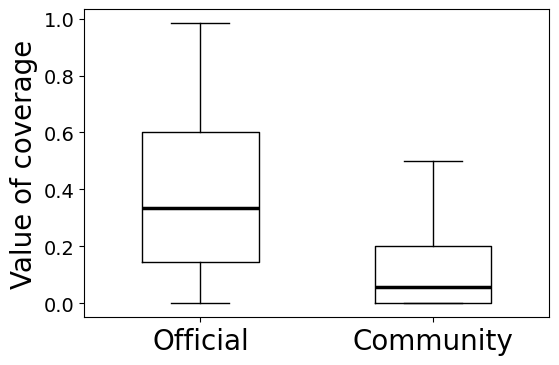

83 / 117 = 70.94017094017094% False
34 / 117 = 29.059829059829063% True


In [17]:
main_package_mask = rq3_bindings["Main Package"] == rq3_bindings["ID"]
coverage_for_show = rq3_bindings[~main_package_mask].drop_duplicates("ID")

official_mask = coverage_for_show["Official?"] == True
for_show_bindings_pid = coverage_for_show["ID"]
official_bindings_pid = coverage_for_show[official_mask]["ID"]
community_bindings_pid = coverage_for_show[~official_mask]["ID"]

title = ""
xticks = ["Official", "Community"]
ylabel = "Value of coverage"
coverage_aList, coverage_bList = coverage_for_show[official_mask]["Coverage"].dropna(), coverage_for_show[~official_mask]["Coverage"].dropna()
fig1, ax1 = plt.subplots()
fig1.set_size_inches((6, 4))
ax1.boxplot([coverage_aList, coverage_bList], widths=0.5, showfliers=False, medianprops=dict(color="black", linewidth="2.5"))
plt.xticks([1, 2], xticks)
ax1.set_ylabel(ylabel, fontsize=20)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=14)
helper.savefig(fig1, "RQ3_ML_Coverage_Compare")
helper.mannUandCliffdelta(coverage_aList, coverage_bList)
plt.show()
    
# helper.boxplotTwoValues(coverage_for_show[official_mask]["Coverage"].dropna(), coverage_for_show[~official_mask]["Coverage"].dropna(), )
helper.printValueCountsPercentage(coverage_for_show["Official?"])


CPAN 6.25
CRAN 4.501915708812261
Cargo 13.414634146341465
Clojars 5.88235294117647
CocoaPods 35.0
Hackage 2.272727272727273
Maven 26.666666666666668
NPM 2.380952380952381
NuGet 8.680555555555555
Packagist 18.181818181818183
Pub 2.1739130434782608
Pypi 45.93023255813954
Rubygems 7.870370370370369
overall: 11.11111111111111
{'CPAN': [0.125, 0.0], 'CRAN': [0.6666666666666666, 0.23958333333333334, 0.631578947368421, 0.0, 0.034482758620689655, 0.05555555555555555, 0.027777777777777776, 0.0, 0.0, 0.6923076923076923], 'Cargo': [0.07547169811320754, 0.2, 0.14285714285714285, 0.0, 1.0, 0.13414634146341464, 0.09836065573770492, 0.3333333333333333, 0.0], 'Clojars': [0.26666666666666666, 0.2, 0.0, 0.058823529411764705, 0.07142857142857142, 0.0, 0.03076923076923077], 'CocoaPods': [1.0, 0.6607142857142857, 0.16666666666666666, 0.0, 0.2, 0.5], 'Hackage': [0.0, 0.022727272727272728, 0.3333333333333333, 0.02702702702702703, 0.0], 'Maven': [0.6515151515151515, 0.26666666666666666, 0.16666666666666666, 0

/tmp/ipykernel_365418/3528458352.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  raw_dict = coverage_for_show.groupby("Platform").apply(lambda x: x["Coverage"].dropna()).to_dict()


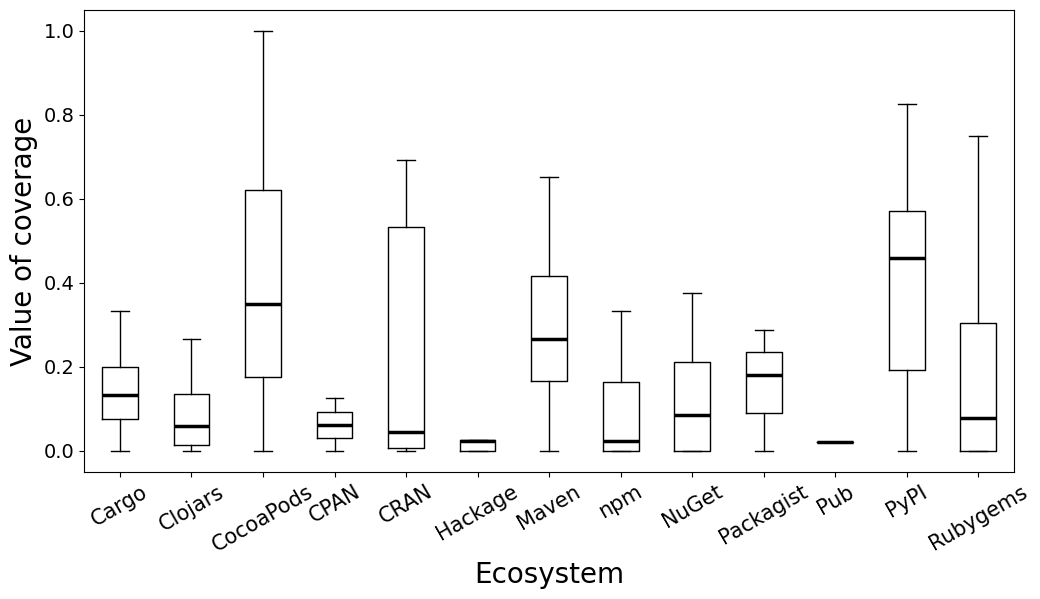

In [18]:
raw_dict = coverage_for_show.groupby("Platform").apply(lambda x: x["Coverage"].dropna()).to_dict()
coverage_for_show_dict = {k[0]: [] for k in raw_dict}
for k, v in raw_dict.items():
    coverage_for_show_dict[k[0]].append(v)

for k, v in coverage_for_show_dict.items():
    print(k, np.median(v) * 100)
print("overall:", np.median(coverage_for_show["Coverage"]) * 100)
print(coverage_for_show_dict)
print(coverage_for_show_dict.keys())
print(helper.PICKUP_PLATFORMS)
figure, ax = plt.subplots()
figure.set_size_inches(helper.FIG_SIZE_WIDE)

ax.boxplot(
    [coverage_for_show_dict[eco] for eco in helper.PICKUP_PLATFORMS],
    widths=0.5, showfliers=False, medianprops=dict(color="black", linewidth="2.5")
)
plt.xticks(list(range(1, len(helper.PICKUP_PLATFORMS) + 1)), helper.PICKUP_PLATFORMS_FOR_SHOWN, fontsize=15, rotation=30)
plt.yticks(fontsize=14)
plt.ylim(-0.05, 1.05)
ax.set_ylabel("Value of coverage", fontsize=20)
ax.set_xlabel("Ecosystem", fontsize=20)
len(helper.PICKUP_PLATFORMS)
list(range(1, len(helper.PICKUP_PLATFORMS) + 1))
helper.savefig(figure, "RQ3_ML_Packages_Coverage")

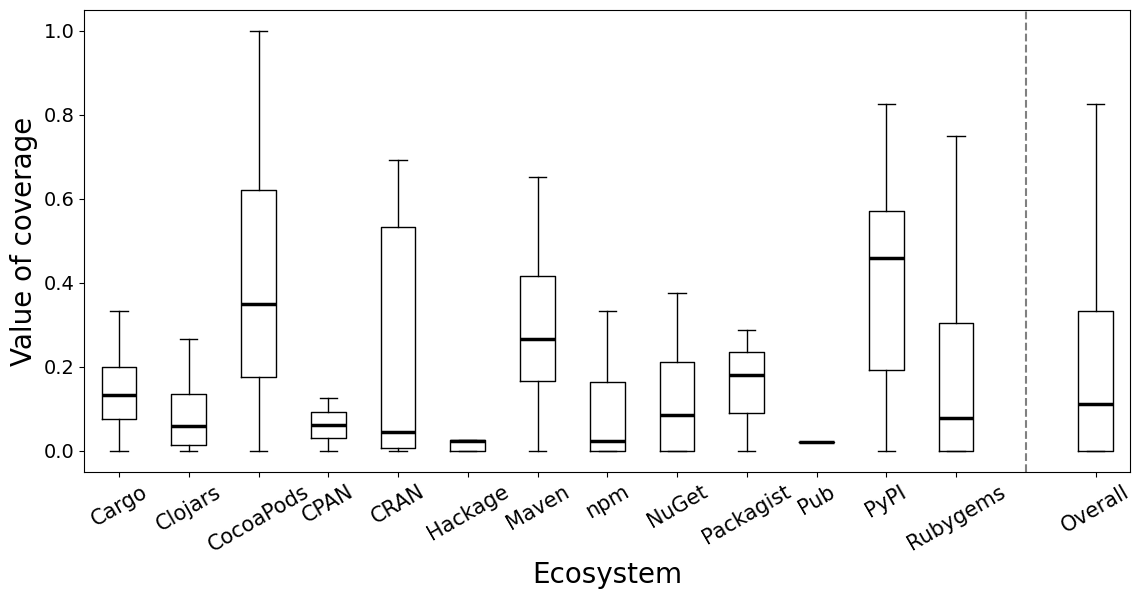

In [19]:
figure, ax = plt.subplots()
# figure.set_size_inches(helper.FIG_SIZE_WIDE)
figure.set_size_inches((13.5, 6))

all_data = [coverage_for_show_dict[eco] for eco in helper.PICKUP_PLATFORMS]
# Add the overall 'Coverage' data to the end of the list
all_data.append(coverage_for_show["Coverage"].dropna().values)

# Calculate custom positions to increase the gap before the 'Overall' boxplot
num_ecosystems = len(helper.PICKUP_PLATFORMS)
gap_width = 1  # Adjust this value to change the gap size
positions = list(range(1, num_ecosystems + 1)) + [num_ecosystems + 1 + gap_width]

ax.boxplot(
    all_data,
    positions=positions,  # Use custom positions
    widths=0.5, showfliers=False, medianprops=dict(color="black", linewidth="2.5")
)

# Add vertical line to separate the last ecosystem from the aggregated data boxplot
ax.axvline(x=num_ecosystems + + 0.5 + gap_width / 2, color='grey', linestyle='--')

plt.xticks(positions, helper.PICKUP_PLATFORMS_FOR_SHOWN + ['Overall'], fontsize=15, rotation=30)
plt.yticks(fontsize=14)
plt.ylim(-0.05, 1.05)
ax.set_ylabel("Value of coverage", fontsize=20)
ax.set_xlabel("Ecosystem", fontsize=20)

# Save the figure
helper.savefig(figure, "RQ3_ML_Packages_Coverage")

In [20]:
helper.printValueCountsPercentage(coverage_for_show["Platform"])
pprint(coverage_for_show.groupby("Platform").apply(lambda x: 1 - sum(x["Official?"]) / len(x)))

for eco in coverage_for_show["Platform"].unique():
    print(eco)
    data = coverage_for_show[coverage_for_show["Platform"] == eco]
    helper.printValueCountsPercentage(data["Matched Version Num"], topn=4)

19 / 117 = 16.23931623931624% NPM
18 / 117 = 15.384615384615385% NuGet
14 / 117 = 11.965811965811966% Pypi
14 / 117 = 11.965811965811966% Rubygems
10 / 117 = 8.547008547008547% CRAN
9 / 117 = 7.6923076923076925% Maven
9 / 117 = 7.6923076923076925% Cargo
7 / 117 = 5.982905982905983% Clojars
6 / 117 = 5.128205128205128% CocoaPods
5 / 117 = 4.273504273504273% Hackage
3 / 117 = 2.564102564102564% Packagist
2 / 117 = 1.7094017094017095% CPAN
1 / 117 = 0.8547008547008548% Pub
Platform
CPAN         1.000000
CRAN         0.600000
Cargo        0.888889
Clojars      1.000000
CocoaPods    0.500000
Hackage      0.800000
Maven        0.222222
NPM          0.842105
NuGet        0.777778
Packagist    0.666667
Pub          1.000000
Pypi         0.428571
Rubygems     0.857143
dtype: float64
Clojars
3 / 7 = 42.857142857142854% 2
2 / 7 = 28.57142857142857% 0
1 / 7 = 14.285714285714285% 4
1 / 7 = 14.285714285714285% 1
Pypi
2 / 14 = 14.285714285714285% 7
2 / 14 = 14.285714285714285% 2
2 / 14 = 14.285714285

/tmp/ipykernel_365418/2052861019.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pprint(coverage_for_show.groupby("Platform").apply(lambda x: 1 - sum(x["Official?"]) / len(x)))


### Version delay

In [21]:
# print(sum(rq3_versions["Matched Tag"] == "0.0.0"))
# display(rq3_versions)

def findMatchTime(df):
    pid = df["ID"]
    versions = rq3_versions[rq3_versions["Project ID"] == pid]
    
    if df["Main Package"] == "repo":
        rid = df["ID Main Repo"]
        matched_tag = df["Matched Tag"]
        if matched_tag == "0.0.0":
            return np.nan
        mask1 = rq3_repo_tags["Repository ID"] == rid
        mask2 = rq3_repo_tags["Tag Name"] == matched_tag
        mask = np.logical_and(mask1, mask2)
        if sum(mask) == 0:
            print("not found 1")
            return np.nan
        
        tags = rq3_repo_tags[mask]
        upstream_timestamp = tags["Tag Published Timestamp"].values[0]
    else:
        main_pid = df["Main Package"]
        
        matched_version = df["Matched Version"]
        if matched_version == "0.0.0":
            return np.nan
        mask1 = rq3_versions["Project ID"] == main_pid
        mask2 = rq3_versions["Number"] == matched_version
        mask = np.logical_and(mask1, mask2)
        if sum(mask) == 0:
            print("not found 2")
            return np.nan
        
        versions = rq3_versions[mask]
        upstream_timestamp = versions["Published Timestamp"].values[0]
        
    return upstream_timestamp

matched_time_series = rq3_versions.apply(findMatchTime, axis=1)

helper.printPercentage(sum(matched_time_series.isna()), len(matched_time_series), "nan")
main_package_repo_mask = rq3_versions["Main Package"] == "repo"
matched_tags_nan_mask = rq3_versions["Matched Tag"] == "0.0.0"
matched_versions_nan_mask = rq3_versions["Matched Version"] == "0.0.0"
helper.printPercentage(sum(np.logical_and(main_package_repo_mask, matched_tags_nan_mask)),len(rq3_versions), "nan repo tag")
helper.printPercentage(sum(np.logical_and(~main_package_repo_mask, matched_versions_nan_mask)),len(rq3_versions), "nan proj versions")

rq3_versions["Matched Timestamp"] = matched_time_series
rq3_versions
# matched_time_series

# print(len(rq3_versions))
# added_tag_info = rq3_versions[["ID", "ID Main Repo", "Matched Tag"]].merge(rq3_repo_tags[["Repository ID", "Tag Name", "Tag Published Timestamp"]], left_on=["ID Main Repo", "Matched Tag"], right_on=["Repository ID", "Tag Name"])
# print(len(added_tag_info))
# rq3_versions.merge(added_tag_info[["ID", "Tag Published Timestamp"]], on="ID", how="left")

553 / 3189 = 17.340859203512075% nan
165 / 3189 = 5.174035747883349% nan repo tag
388 / 3189 = 12.166823455628723% nan proj versions


,Host Repo IDs,Project ID,Platform,Project Name,Number,Published Timestamp,Matched Tag,Matched Version,ID,Created Timestamp,Updated Timestamp,Main Package,ID Main Repo,Matched Timestamp
568,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp-AnyCPU,2.4.8.20140522,2014-05-23 03:26:20,2.4.8,NaN,2405925,2015-02-18 04:12:42 UTC,2015-02-18 04:12:42 UTC,repo,851991,2013-12-27 21:30:03
569,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp-AnyCPU,2.4.8.20140523,2014-05-23 04:00:57,2.4.8,NaN,2405926,2015-02-18 04:12:42 UTC,2015-02-18 04:12:42 UTC,repo,851991,2013-12-27 21:30:03
570,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp-AnyCPU,2.4.8.20140527,2014-05-27 12:32:55,2.4.8,NaN,2405927,2015-02-18 04:12:42 UTC,2015-02-18 04:12:42 UTC,repo,851991,2013-12-27 21:30:03
571,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp-AnyCPU,2.4.8.20140529,2014-05-30 07:47:56,2.4.8,NaN,2405928,2015-02-18 04:12:42 UTC,2015-02-18 04:12:42 UTC,repo,851991,2013-12-27 21:30:03
572,851991,1018886+3498980+3498982+624343+631591,NuGet,OpenCvSharp-AnyCPU,2.4.8.20140607,2014-06-08 02:12:48,2.4.8,NaN,2405929,2015-02-18 04:12:42 UTC,2015-02-18 04:12:42 UTC,repo,851991,2013-12-27 21:30:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,852009,999771,Clojars,engagor/clj-vw,1.0.1,2015-10-05 07:40:48,0.0.0,NaN,3905030,2015-10-05 07:40:48 UTC,2015-10-05 07:40:48 UTC,repo,852009,NaT
1069,852009,999771,Clojars,engagor/clj-vw,1.1.0,2015-10-05 07:40:48,0.0.0,NaN,3905029,2015-10-05 07:40:48 UTC,2015-10-05 07:40:48 UTC,repo,852009,NaT
1070,852009,999771,Clojars,engagor/clj-vw,1.1.1,2015-10-05 07:40:48,0.0.0,NaN,3905028,2015-10-05 07:40:48 UTC,2015-10-05 07:40:48 UTC,repo,852009,NaT
1071,852009,999771,Clojars,engagor/clj-vw,1.1.2,2015-12-22 01:01:52,0.0.0,NaN,4529503,2015-12-22 01:01:52 UTC,2015-12-22 01:01:52 UTC,repo,852009,NaT


In [22]:
rq3_versions["Delay"] = rq3_versions["Published Timestamp"] - rq3_versions["Matched Timestamp"]
rq3_versions["Delay_days"] = rq3_versions["Delay"].apply(lambda d: helper.secondsToDays(d.total_seconds()))
def findTheFirstDelay(df):
    # display(df)
    after = df.drop_duplicates(["Matched Timestamp"], keep='first')
    # print(len(df), "->", len(after))
    # display(after)
    if len(after["Delay_days"]):
        return after["Delay_days"].median()
    return np.nan

delay_days = rq3_versions.groupby("Project ID").apply(findTheFirstDelay).reset_index().rename(columns={"Project ID": "ID", 0: "Median Delay"})
delay_days
# delay_days = rq3_versions.groupby("Project ID").apply(lambda x: x["Delay_days"].median()).reset_index().rename(columns={"Project ID": "ID", 0: "Median Delay"})

/home/jupyter-lihao/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/jupyter-lihao/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/jupyter-lihao/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/jupyter-lihao/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/jupyter-lihao/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/jupyter-lihao/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarnin

,ID,Median Delay
0,1018886+3498980+3498982+624343+631591,34.446076
1,1023481,7.850775
2,1028546,108.112130
3,103324,0.228461
4,1059717,246.474294
...,...,...
132,825940,0.000000
133,932668,1.262558
134,950277,213.837616
135,993924,0.020289


In [23]:
# rq3_versions["Delay"] = rq3_versions["Published Timestamp"] - rq3_versions["Matched Timestamp"]
# rq3_versions["Delay_days"] = rq3_versions["Delay"].apply(lambda d: helper.secondsToDays(d.total_seconds()))
# delay_days = rq3_versions.groupby("Project ID").apply(lambda x: x["Delay_days"].median()).reset_index().rename(columns={"Project ID": "ID", 0: "Median Delay"})
display(delay_days)
if "Median Delay" in rq3_bindings.columns:
    rq3_bindings.drop("Median Delay", axis=1, inplace=True)
rq3_bindings = rq3_bindings.merge(delay_days, how="left", on="ID")
rq3_bindings[rq3_bindings["Median Delay"] < 0]


,ID,Median Delay
0,1018886+3498980+3498982+624343+631591,34.446076
1,1023481,7.850775
2,1028546,108.112130
3,103324,0.228461
4,1059717,246.474294
...,...,...
132,825940,0.000000
133,932668,1.262558
134,950277,213.837616
135,993924,0.020289


,Auto Aligned,Binding Type,Initial Aligned Version,Aligned Note,Manual Inspection Notes,Binding?,Related?,Official?,Main package?,ID,...,Binding Host Normalized,Binding Host Normalized - No Space,ID Main Repo,Main Package,Matched Tag Span Start,Matched Version Span Start,Matched Version Num,Main Version Num,Coverage,Median Delay
13,Y,NaN,NaN,Scala API,NaN,True,True,True,NaN,2301217+2417372,...,NaN,NaN,527263,334746,NaT,2016-07-02 02:56:42,43,66,0.651515,-0.140289
14,Y,NaN,NaN,"lost record after 3.22.1.5, https://mvnreposit...",NaN,True,True,True,NaN,2301217+2417372,...,NaN,NaN,527263,334746,NaT,2016-07-02 02:56:42,43,66,0.651515,-0.140289
90,Y,NaN,NaN,NaN,NaN,True,False,True,NaN,1263173,...,libpostal,libpostal,2895492,repo,2016-03-15 15:00:58,NaT,4,9,0.444444,-0.682037
91,N,NaN,NaN,NaN,NaN,True,False,True,NaN,1283582,...,libpostal,libpostal,2895492,repo,2016-03-23 19:26:15,NaT,3,9,0.333333,-1.585069
116,Y,NaN,NaN,NaN,NaN,True,True,True,NaN,3491004,...,NaN,NaN,10661363,2524869,NaT,2018-12-23 12:53:15,6,35,0.171429,-0.030417
125,Y,NaN,NaN,NaN,both official,True,True,True,NaN,2592754,...,bigdl,bigdl,17894687,2343634,NaT,2018-01-03 03:57:31,8,10,0.800000,-1.143918


,Auto Aligned,Binding Type,Initial Aligned Version,Aligned Note,Manual Inspection Notes,Binding?,Related?,Official?,Main package?,ID,...,Binding Host Normalized,Binding Host Normalized - No Space,ID Main Repo,Main Package,Matched Tag Span Start,Matched Version Span Start,Matched Version Num,Main Version Num,Coverage,Median Delay
0,main,NaN,NaN,NaN,NaN,True,True,True,True,3122840+353059,...,NaN,NaN,165170,3122840+353059,NaT,2014-02-22 18:54:22,47,57,0.824561,0.0
1,Y,NaN,NaN,NaN,"one ecosystem, two bindings",True,True,True,NaN,3122840+353059,...,deeplearning4j,deeplearning4j,165170,3122840+353059,NaT,2014-02-22 18:54:22,47,57,0.824561,0.0
3,main,NaN,NaN,NaN,NaN,True,False,True,True,2239255,...,alluxio,alluxio,168500,2239255,NaT,2016-02-23 09:08:55,13,13,1.000000,0.0
11,Y,NaN,NaN,"more releases, what a mess before 3.10.4.5",readme (https://github.com/h2oai/h2o-3?tab=rea...,True,True,True,True,334746,...,NaN,NaN,527263,334746,NaT,2015-01-29 08:02:41,96,96,1.000000,0.0
23,Y,NaN,NaN,"Same as GitHub, perfectly aligned",NaN,True,True,True,True,825940,...,NaN,NaN,815940,825940,NaT,2015-06-14 00:36:35,48,48,1.000000,0.0
29,Y,NaN,NaN,less in PyPI https://pypi.org/project/scikit-l...,NaN,True,True,True,True,702828,...,NaN,NaN,845049,702828,NaT,2011-09-22 00:03:10,43,43,1.000000,0.0
32,Y,NaN,NaN,"lost tags in the dataset, https://github.com/n...",NaN,True,False,False,True,61313,...,NaN,NaN,845081,61313,NaT,2009-07-15 09:32:16,37,37,1.000000,0.0
35,Y,NaN,NaN,"different with GitHub, more releases on PyPI, ...",NaN,True,True,True,True,79381,...,NaN,NaN,845210,79381,NaT,2015-01-02 17:43:40,157,157,1.000000,0.0
64,Y,NaN,NaN,NaN,NaN,True,True,True,True,2209597,...,NaN,NaN,852055,2209597,NaT,2017-04-03 06:19:44,168,168,1.000000,0.0
88,Y,NaN,NaN,NaN,NaN,True,True,True,True,2349511,...,NaN,NaN,2708615,2349511,NaT,2017-07-02 15:31:47,22,22,1.000000,0.0


,Auto Aligned,Binding Type,Initial Aligned Version,Aligned Note,Manual Inspection Notes,Binding?,Related?,Official?,Main package?,ID,...,Binding Host Normalized,Binding Host Normalized - No Space,ID Main Repo,Main Package,Matched Tag Span Start,Matched Version Span Start,Matched Version Num,Main Version Num,Coverage,Median Delay
13,Y,NaN,NaN,Scala API,NaN,True,True,True,NaN,2301217+2417372,...,NaN,NaN,527263,334746,NaT,2016-07-02 02:56:42,43,66,0.651515,-0.140289
90,Y,NaN,NaN,NaN,NaN,True,False,True,NaN,1263173,...,libpostal,libpostal,2895492,repo,2016-03-15 15:00:58,NaT,4,9,0.444444,-0.682037
91,N,NaN,NaN,NaN,NaN,True,False,True,NaN,1283582,...,libpostal,libpostal,2895492,repo,2016-03-23 19:26:15,NaT,3,9,0.333333,-1.585069
116,Y,NaN,NaN,NaN,NaN,True,True,True,NaN,3491004,...,NaN,NaN,10661363,2524869,NaT,2018-12-23 12:53:15,6,35,0.171429,-0.030417
125,Y,NaN,NaN,NaN,both official,True,True,True,NaN,2592754,...,bigdl,bigdl,17894687,2343634,NaT,2018-01-03 03:57:31,8,10,0.800000,-1.143918


5 / 117 = 4.273504273504273% negative delta time
30 53
Cliff's delta: large, d=-0.8188679245283019
Mann-Whitney-U-test: u=144.0 p=7.006298216605689e-10


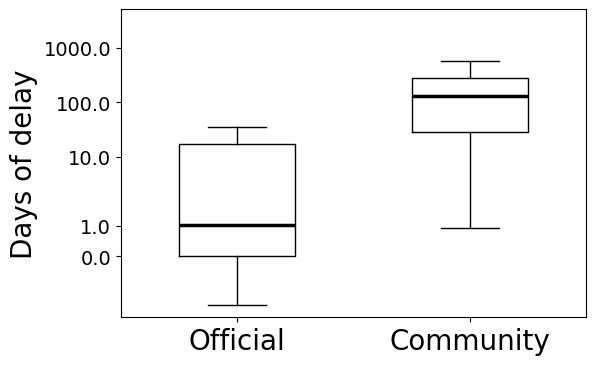

In [24]:
main_package_mask = rq3_bindings["Main Package"] == rq3_bindings["ID"]
display(rq3_bindings[main_package_mask])
delay_for_show = rq3_bindings[~main_package_mask].drop_duplicates("ID")

negative_mask = delay_for_show["Median Delay"] < 0
display(delay_for_show[negative_mask])
helper.printPercentage(sum(negative_mask), len(delay_for_show), "negative delta time")

official_binding_versions = delay_for_show[delay_for_show["ID"].isin(official_bindings_pid)]
official_delays = official_binding_versions["Median Delay"].dropna()

community_binding_versions = delay_for_show[delay_for_show["ID"].isin(community_bindings_pid)]
community_delays = community_binding_versions["Median Delay"].dropna()
print(len(official_delays), len(community_delays))

xticks = ["Official", "Community"]
ylabel = "Days of delay"
title = ""
textFmt="{:.1f}"

delay_aList, delay_bList = official_delays, community_delays
fig1, ax1 = plt.subplots()
fig1.set_size_inches((6, 4))
ax1.boxplot([delay_aList, delay_bList], widths=0.5, showfliers=False, medianprops=dict(color="black", linewidth="2.5"))
plt.xticks([1, 2], xticks)
ax1.set_ylabel(ylabel, fontsize=20)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=14)
# ax1.set_title(title, fontsize=25)

plt.yscale('symlog')
yticks = [0, 1, 10, 100, 1000, 10000]
plt.yticks(yticks, list(map(lambda x: str(x) + ".0", yticks)), fontsize=14)
plt.ylim(-2, 5000)

helper.savefig(fig1, "RQ3_ML_Delay_Compare")
helper.mannUandCliffdelta(delay_aList, delay_bList)
plt.show()

# delay_for_show[negative_mask]
# delay_for_show

lower_whisker: [0.1434669 0.       ]
upper_whisker: [0.60336538 0.98360656]
lower_quartile: [0.1434669  0.1434669  0.60336538 0.60336538 0.1434669 ]
lower_quartile: [0.  0.  0.2 0.2 0. ]
lower_whisker: [ 0.01413918 -1.58506944]
upper_whisker: [17.54659722 35.60679398]
lower_quartile: [1.41391782e-02 1.41391782e-02 1.75465972e+01 1.75465972e+01
 1.41391782e-02]
lower_quartile: [ 29.17431713  29.17431713 274.66469907 274.66469907  29.17431713]


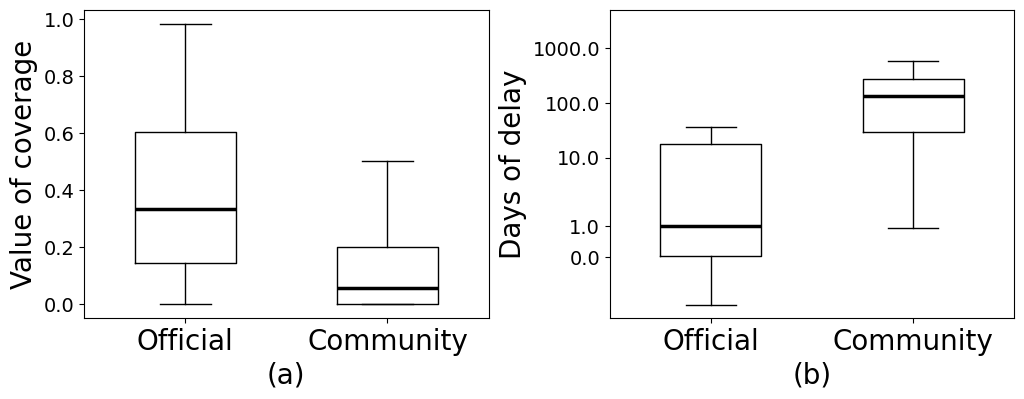

In [25]:
figure, (ax1, ax2) = plt.subplots(1, 2)
figure.set_size_inches((12, 4))
plt.subplots_adjust(wspace=0.3)

ax1 = plt.subplot(1, 2, 1)
bp = ax1.boxplot([coverage_aList, coverage_bList], widths=0.5, showfliers=False, medianprops=dict(color="black", linewidth="2.5"))
print("lower_whisker:", bp['whiskers'][0].get_ydata())
print("upper_whisker:", bp['whiskers'][1].get_ydata())
print("lower_quartile:", bp['boxes'][0].get_ydata())
print("lower_quartile:", bp['boxes'][1].get_ydata())
plt.xticks(list(range(1, len(["Official", "Community"]) + 1)), ["Official", "Community"], fontsize=20)
plt.yticks(fontsize=14)
ax1.set_ylabel("Value of coverage", fontsize=20)
ax1.set_xlabel("(a)", fontsize=20)

ax2 = plt.subplot(1, 2, 2)
bp = ax2.boxplot(
    [delay_aList, delay_bList],
    widths=0.5, showfliers=False, medianprops=dict(color="black", linewidth="2.5")
)
print("lower_whisker:", bp['whiskers'][0].get_ydata())
print("upper_whisker:", bp['whiskers'][1].get_ydata())
print("lower_quartile:", bp['boxes'][0].get_ydata())
print("lower_quartile:", bp['boxes'][1].get_ydata())
plt.yscale('symlog')
yticks = [0, 1, 10, 100, 1000, 10000]
plt.yticks(yticks, list(map(lambda x: str(x) + ".0", yticks)), fontsize=14)
plt.xticks(list(range(1, len(["Official", "Community"]) + 1)), ["Official", "Community"], fontsize=20)
plt.ylim(-2, 5000)
ax2.set_ylabel("Days of delay", fontsize=20)
ax2.set_xlabel("(b)", fontsize=20)
helper.savefig(figure, "RQ3_ML_Packages_Official")

/tmp/ipykernel_365418/3742088928.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  raw_dict = delay_for_show.groupby("ID").apply(lambda x: x["Median Delay"].dropna()).to_dict()


NuGet 29.174317129629628
Packagist 818.2781336805557
Cargo 137.11630787037038
Pypi 3.419765625
Hackage 492.5553125
Rubygems 25.4959375
NPM 106.08743923611112
CPAN 20.779953703703704
CRAN 26.618090277777778
Maven 0.3712702546296296
CocoaPods 132.68197916666668
Clojars 274.66469907407406
Pub 52.55325231481481
Overall: 34.44607638888889
dict_keys(['NuGet', 'Packagist', 'Cargo', 'Pypi', 'Hackage', 'Rubygems', 'NPM', 'CPAN', 'CRAN', 'Maven', 'CocoaPods', 'Clojars', 'Pub'])
['Cargo', 'Clojars', 'CocoaPods', 'CPAN', 'CRAN', 'Hackage', 'Maven', 'NPM', 'NuGet', 'Packagist', 'Pub', 'Pypi', 'Rubygems']


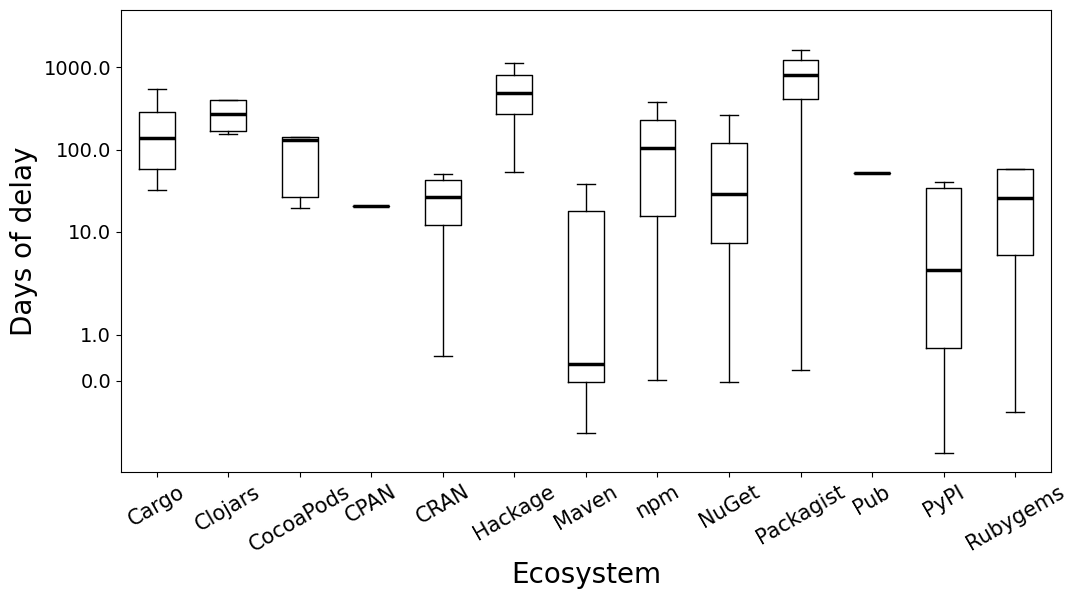

In [26]:
pid2platform = {raw["ID"]: raw["Platform"] for _, raw in rq3_bindings.iterrows()}

raw_dict = delay_for_show.groupby("ID").apply(lambda x: x["Median Delay"].dropna()).to_dict()
delay_for_show_dict = {pid2platform[k[0]]: [] for k in raw_dict}
for k, v in raw_dict.items():
    delay_for_show_dict[pid2platform[k[0]]].append(v)

for k, v in delay_for_show_dict.items():
    print(k, np.median(v))
print("Overall:", np.median(delay_for_show["Median Delay"].dropna().values))
# print(delay_for_show_dict)
print(delay_for_show_dict.keys())
print(helper.PICKUP_PLATFORMS)
figure, ax = plt.subplots()
figure.set_size_inches(helper.FIG_SIZE_WIDE)

ax.boxplot(
    [delay_for_show_dict[eco] for eco in helper.PICKUP_PLATFORMS],
    widths=0.5, showfliers=False, medianprops=dict(color="black", linewidth="2.5")
)
plt.xticks(list(range(1, len(helper.PICKUP_PLATFORMS) + 1)), helper.PICKUP_PLATFORMS_FOR_SHOWN, fontsize=15, rotation=30)
plt.yscale('symlog')
yticks = [0, 1, 10, 100, 1000, 10000]
plt.yticks(yticks, list(map(lambda x: str(x) + ".0", yticks)), fontsize=14)
plt.ylim(-2, 5000)
ax.set_ylabel("Days of delay", fontsize=20)
ax.set_xlabel("Ecosystem", fontsize=20)
len(helper.PICKUP_PLATFORMS)
list(range(1, len(helper.PICKUP_PLATFORMS) + 1))
helper.savefig(figure, "RQ3_ML_Package_Updates_Delay")

In [27]:
delay_for_show

,Auto Aligned,Binding Type,Initial Aligned Version,Aligned Note,Manual Inspection Notes,Binding?,Related?,Official?,Main package?,ID,...,Binding Host Normalized,Binding Host Normalized - No Space,ID Main Repo,Main Package,Matched Tag Span Start,Matched Version Span Start,Matched Version Num,Main Version Num,Coverage,Median Delay
2,N,NaN,NaN,look dep info in https://clojars.org/hswick/ju...,NaN,True,False,False,NaN,3581741,...,deeplearning4j,deeplearning4j,165170,3122840+353059,NaT,2017-03-11 09:47:25,4,15,0.266667,396.275069
4,N,NaN,NaN,NaN,official without link,True,False,False,NaN,2424129,...,alluxio,alluxio,168500,2239255,NaT,2017-06-12 06:31:39,1,6,0.166667,86.865972
5,N,NaN,NaN,"add a dash after the version number, check htt...",NaN,True,True,True,NaN,689683,...,NaN,NaN,339654,repo,2014-09-01 19:47:00,NaT,8,12,0.666667,50.539491
6,Y,NaN,NaN,"more pre-releases, https://pypi.org/project/xg...",NaN,True,True,True,NaN,932668,...,NaN,NaN,339654,repo,2015-05-12 06:44:02,NaT,9,11,0.818182,1.262558
7,N,NaN,NaN,NaN,NaN,True,False,False,NaN,1985474,...,xgboost,xgboost,339654,repo,2016-07-29 18:23:06,NaT,1,8,0.125000,129.356736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,N,NaN,NaN,NaN,NaN,True,False,False,NaN,4347686,...,bert as service,bertasservice,36916440,3446917,NaT,2019-08-26 18:09:42,0,4,0.000000,NaN
150,Y,NaN,NaN,"different releases with GitHub tags, https://p...",NaN,True,False,False,NaN,3263375,...,NaN,NaN,37310670,repo,2018-09-21 19:21:33,NaT,7,12,0.583333,0.937245
151,Y,NaN,NaN,"different releases with GitHub tags, https://g...",NaN,True,True,True,NaN,3657657,...,NaN,NaN,37310670,repo,2018-12-01 01:32:58,NaT,10,11,0.909091,0.790660
152,Y,NaN,NaN,check https://github.com/fs-eire/onnxjs-node/b...,NaN,True,False,False,NaN,3698104,...,onnxruntime,onnxruntime,37310670,repo,2019-01-31 22:33:09,NaT,3,9,0.333333,9.902685


/tmp/ipykernel_365418/3324082957.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  raw_dict = delay_for_show.groupby("ID").apply(lambda x: x["Median Delay"].dropna()).to_dict()


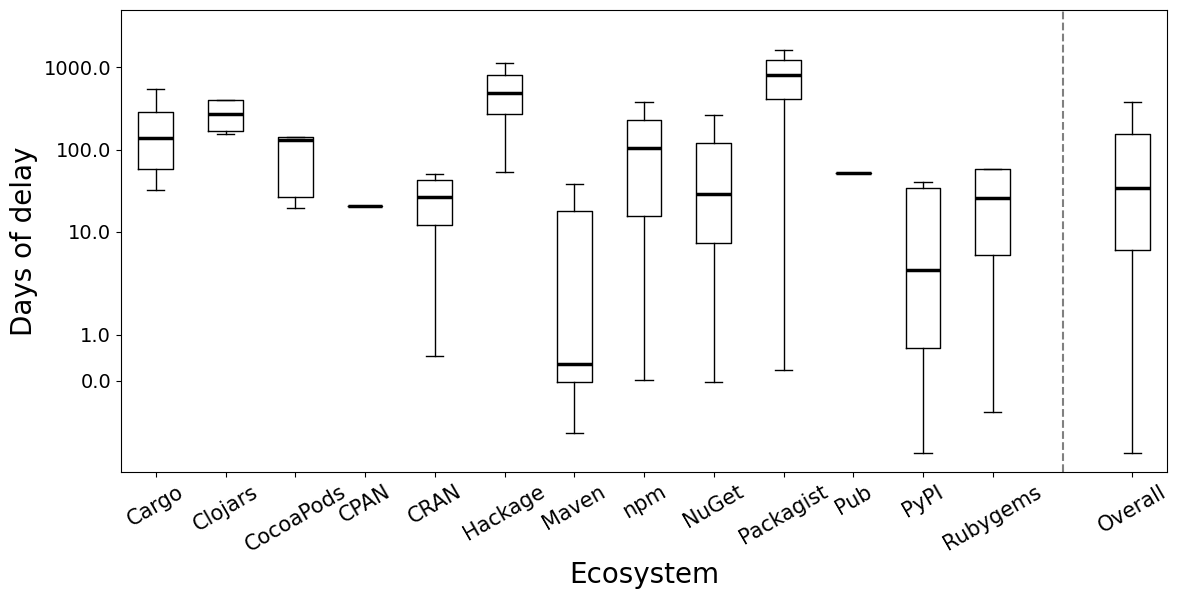

In [28]:
pid2platform = {raw["ID"]: raw["Platform"] for _, raw in rq3_bindings.iterrows()}

raw_dict = delay_for_show.groupby("ID").apply(lambda x: x["Median Delay"].dropna()).to_dict()
delay_for_show_dict = {pid2platform[k[0]]: [] for k in raw_dict}  
for k, v in raw_dict.items():
    delay_for_show_dict[pid2platform[k[0]]].append(v)

# Calculate the overall median delay
overall_delay = delay_for_show["Median Delay"].dropna().values

figure, ax = plt.subplots()
# figure.set_size_inches(helper.FIG_SIZE_WIDE)
figure.set_size_inches((13.5, 6))


all_data = [delay_for_show_dict[eco] for eco in helper.PICKUP_PLATFORMS]
# Append the overall delay data
all_data.append(overall_delay)

# Custom positions with a gap before the 'Overall'
num_platforms = len(helper.PICKUP_PLATFORMS)
gap_width = 1
positions = list(range(1, num_platforms + 1)) + [num_platforms + 1 + gap_width]

ax.boxplot(
    all_data,
    positions=positions,
    widths=0.5, showfliers=False, medianprops=dict(color="black", linewidth="2.5")
)

# Visual separator
ax.axvline(x=num_platforms + 0.5 + gap_width / 2, color='grey', linestyle='--')

plt.xticks(positions, helper.PICKUP_PLATFORMS_FOR_SHOWN + ['Overall'], fontsize=15, rotation=30)
plt.yscale('symlog')
yticks = [0, 1, 10, 100, 1000, 10000]
plt.yticks(yticks, [f"{x}.0" for x in yticks], fontsize=14)
plt.ylim(-2, 5000)
ax.set_ylabel("Days of delay", fontsize=20)
ax.set_xlabel("Ecosystem", fontsize=20)

helper.savefig(figure, "RQ3_ML_Package_Updates_Delay")

## Technical lag

In [29]:
semver.Version(1, 2, 3)

Version(major=1, minor=2, patch=3, prerelease=None, build=None)

In [30]:
def toSemver(version: str):
    try:
        v1 = packaging.version.parse(version)
        return semver.Version(v1.major, v1.minor, v1.micro)
    except packaging.version.InvalidVersion:
        try:
            return semver.Version.parse(version, True)
        except ValueError:
            return semver.Version(0, 0, 0)

def deltaVersion(a, b):
    if a.major > b.major:
        return (a.major - b.major, 0, 0)
    if a.minor > b.minor:
        return (a.major - b.major, a.minor - b.minor, 0)
    return (a.major - b.major, a.minor - b.minor, a.patch - b.patch)

def calTechLag(bindVer, hostVers):
    major_lag = 0
    minor_lag = 0
    micro_lag = 0
    for v in hostVers:
        major_diff = v.major - bindVer.major
        if major_diff > major_lag:
            major_lag = major_diff
        
        if major_diff == 0:
            minor_diff = v.minor - bindVer.minor
            if minor_diff > minor_lag:
                minor_lag = minor_diff
            
            if minor_diff == 0:
                micro_diff = v.patch - bindVer.patch
                if micro_diff > micro_lag:
                    micro_lag = micro_diff
    return major_lag, minor_lag, micro_lag
# def findLastSemver(versions):
#     max(versions)

a = toSemver("2.2")
b = toSemver("4.1.2-openvino")
c = toSemver("3.1.2-openvino")
d = toSemver("1.1.2openvino")
x = [a, c, d, b]
x.sort()
for i in x:
    print(i, i.major, i.minor, i.patch)
print(max(x))
x

host_vers = [toSemver("1.0.0"), toSemver("1.0.1"), toSemver("1.0.2"), toSemver("1.1.0"), toSemver("2.0.0"), toSemver("2.0.1")]
calTechLag(toSemver("1.0.0"), host_vers)

0.0.0 0 0 0
2.2.0 2 2 0
3.1.2-openvino 3 1 2
4.1.2-openvino 4 1 2
4.1.2-openvino


(1, 1, 2)

In [31]:
def lastVersion(df):
    assert len(df["Project ID"].unique()) == 1
    pid = df["Project ID"].values[0]
    assert len(df["Main Package"].unique()) == 1
    main_package = df["Main Package"].values[0]
    versions = rq3_versions[rq3_versions["Project ID"] == pid]
    
    if main_package == "repo":
        rid = df["ID Main Repo"].values[0]
        matched_tag = df["Matched Tag"].dropna()
        valid_tags = matched_tag[matched_tag != "0.0.0"]
        if len(valid_tags) == 0:
            return np.nan
        
        downstream_latest_version = max(valid_tags.apply(toSemver))
        tags = rq3_repo_tags[rq3_repo_tags["Repository ID"] == rid]
        upstream_versions = tags["Tag Name"].apply(toSemver)
    else:
        main_pid = main_package
        
        matched_versions = df["Matched Version"]
        valid_versions = matched_versions[matched_versions != "0.0.0"]
        if len(valid_versions) == 0:
            return np.nan
        downstream_latest_version = max(valid_versions.apply(toSemver))
        
        versions = rq3_versions[rq3_versions["Project ID"] == main_pid]
        upstream_versions = versions["Number"].apply(toSemver)
    if downstream_latest_version == semver.Version(0, 0, 0):
        return np.nan
    lag = calTechLag(downstream_latest_version, upstream_versions)
    # print(downstream_latest_version)
    # print(upstream_versions.values)
    # print(lag)
    return lag

version_diff = rq3_versions.groupby("Project ID").apply(lastVersion)
helper.printValueCountsPercentage(version_diff, topn=5)
version_diff = version_diff.reset_index().rename(columns={"Project ID": "ID", 0: "Version Diff"})

if "Version Diff" in rq3_bindings.columns:
    rq3_bindings.drop("Version Diff", axis=1, inplace=True)
rq3_bindings = rq3_bindings.merge(version_diff, how="left", on="ID")
rq3_bindings

44 / 137 = 32.11678832116788% (0, 0, 0)
38 / 137 = 27.73722627737226% nan
12 / 137 = 8.75912408759124% (0, 1, 0)
3 / 137 = 2.18978102189781% (0, 0, 1)
3 / 137 = 2.18978102189781% (1, 2, 0)


/tmp/ipykernel_365418/1279868559.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  version_diff = rq3_versions.groupby("Project ID").apply(lastVersion)


,Auto Aligned,Binding Type,Initial Aligned Version,Aligned Note,Manual Inspection Notes,Binding?,Related?,Official?,Main package?,ID,...,Binding Host Normalized - No Space,ID Main Repo,Main Package,Matched Tag Span Start,Matched Version Span Start,Matched Version Num,Main Version Num,Coverage,Median Delay,Version Diff
0,main,NaN,NaN,NaN,NaN,True,True,True,True,3122840+353059,...,NaN,165170,3122840+353059,NaT,2014-02-22 18:54:22,47,57,0.824561,0.000000,"(0, 0, 0)"
1,Y,NaN,NaN,NaN,"one ecosystem, two bindings",True,True,True,NaN,3122840+353059,...,deeplearning4j,165170,3122840+353059,NaT,2014-02-22 18:54:22,47,57,0.824561,0.000000,"(0, 0, 0)"
2,N,NaN,NaN,look dep info in https://clojars.org/hswick/ju...,NaN,True,False,False,NaN,3581741,...,deeplearning4j,165170,3122840+353059,NaT,2017-03-11 09:47:25,4,15,0.266667,396.275069,"(0, 0, 0)"
3,main,NaN,NaN,NaN,NaN,True,False,True,True,2239255,...,alluxio,168500,2239255,NaT,2016-02-23 09:08:55,13,13,1.000000,0.000000,"(0, 0, 0)"
4,N,NaN,NaN,NaN,official without link,True,False,False,NaN,2424129,...,alluxio,168500,2239255,NaT,2017-06-12 06:31:39,1,6,0.166667,86.865972,"(0, 3, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,N,NaN,NaN,NaN,NaN,True,False,False,NaN,4347686,...,bertasservice,36916440,3446917,NaT,2019-08-26 18:09:42,0,4,0.000000,NaN,NaN
150,Y,NaN,NaN,"different releases with GitHub tags, https://p...",NaN,True,False,False,NaN,3263375,...,NaN,37310670,repo,2018-09-21 19:21:33,NaT,7,12,0.583333,0.937245,"(0, 0, 0)"
151,Y,NaN,NaN,"different releases with GitHub tags, https://g...",NaN,True,True,True,NaN,3657657,...,NaN,37310670,repo,2018-12-01 01:32:58,NaT,10,11,0.909091,0.790660,"(0, 0, 0)"
152,Y,NaN,NaN,check https://github.com/fs-eire/onnxjs-node/b...,NaN,True,False,False,NaN,3698104,...,onnxruntime,37310670,repo,2019-01-31 22:33:09,NaT,3,9,0.333333,9.902685,"(1, 1, 0)"


In [32]:
helper.printValueCountsPercentage(rq3_bindings["Median Delay"].isna())
helper.printValueCountsPercentage(rq3_bindings[rq3_bindings["Official?"]]["Median Delay"].isna())
helper.printValueCountsPercentage(rq3_bindings[~rq3_bindings["Official?"]]["Median Delay"].isna())

116 / 154 = 75.32467532467533% False
38 / 154 = 24.675324675324674% True
51 / 55 = 92.72727272727272% False
4 / 55 = 7.2727272727272725% True
65 / 99 = 65.65656565656566% False
34 / 99 = 34.34343434343434% True


In [33]:
mask = rq3_bindings["Main Package"] == rq3_bindings["ID"]
sum(mask)
tech_lag_for_show = rq3_bindings[~mask].drop_duplicates("ID").copy()
helper.printValueCountsPercentage(tech_lag_for_show["Version Diff"])
print("official_df")
mask = tech_lag_for_show["ID"].isin(official_bindings_pid)
official_df = tech_lag_for_show[mask]
helper.printValueCountsPercentage(official_df["Version Diff"])

print("community_df")
community_df = tech_lag_for_show[~mask]
helper.printValueCountsPercentage(community_df["Version Diff"])

38 / 117 = 32.47863247863248% nan
25 / 117 = 21.367521367521366% (0, 0, 0)
12 / 117 = 10.256410256410255% (0, 1, 0)
3 / 117 = 2.564102564102564% (1, 2, 0)
3 / 117 = 2.564102564102564% (0, 0, 1)
2 / 117 = 1.7094017094017095% (1, 0, 0)
2 / 117 = 1.7094017094017095% (1, 6, 0)
2 / 117 = 1.7094017094017095% (0, 1, 1)
2 / 117 = 1.7094017094017095% (0, 3, 0)
2 / 117 = 1.7094017094017095% (2, 0, 0)
2 / 117 = 1.7094017094017095% (1, 1, 0)
2 / 117 = 1.7094017094017095% (0, 4, 0)
1 / 117 = 0.8547008547008548% (0, 2, 3)
1 / 117 = 0.8547008547008548% (1, 3, 0)
1 / 117 = 0.8547008547008548% (1, 11, 0)
1 / 117 = 0.8547008547008548% (1, 8, 1)
1 / 117 = 0.8547008547008548% (1, 13, 1)
1 / 117 = 0.8547008547008548% (0, 30, 0)
1 / 117 = 0.8547008547008548% (0, 18, 0)
1 / 117 = 0.8547008547008548% (1, 2, 1)
1 / 117 = 0.8547008547008548% (0, 17, 0)
1 / 117 = 0.8547008547008548% (0, 15, 0)
1 / 117 = 0.8547008547008548% (1, 1, 1)
1 / 117 = 0.8547008547008548% (1, 4, 0)
1 / 117 = 0.8547008547008548% (0, 7, 2)


In [34]:
tech_lag_for_show["Major Lag"] = tech_lag_for_show.apply(lambda x: x["Version Diff"][0] if isinstance(x["Version Diff"], tuple) else np.nan, axis=1)
tech_lag_for_show["Minor Lag"] = tech_lag_for_show.apply(lambda x: x["Version Diff"][1] if isinstance(x["Version Diff"], tuple) else np.nan, axis=1)
tech_lag_for_show["Micro Lag"] = tech_lag_for_show.apply(lambda x: x["Version Diff"][2] if isinstance(x["Version Diff"], tuple) else np.nan, axis=1)


tech_lag_res = tech_lag_for_show[~tech_lag_for_show["Version Diff"].isna()]
official_mask = tech_lag_res["ID"].isin(official_bindings_pid)
official_df = tech_lag_res[official_mask]
community_df = tech_lag_res[~official_mask]

def inspect(df):
    no_lag_mask = df["Version Diff"] == (0, 0, 0)
    helper.printPercentage(sum(no_lag_mask), len(df), "no lag")
    
    major_lag = df["Version Diff"].apply(lambda x: x[0] != 0)
    helper.printPercentage(sum(major_lag), len(df), "major lag")
    print(df[major_lag]["Major Lag"].median())
    
    minor_lag = df["Version Diff"].apply(lambda x: np.logical_and(x[0] == 0, x[1] != 0))
    helper.printPercentage(sum(minor_lag), len(df), "minor lag")
    print(df[minor_lag]["Minor Lag"].median())
    
    micro_lag = df["Version Diff"].apply(lambda x: np.logical_and(x[0] == 0, np.logical_and(x[1] == 0, x[2] != 0)))
    helper.printPercentage(sum(micro_lag), len(df), "micro lag")
    print(df[micro_lag]["Micro Lag"].median())
    

print("="*20, "all", "="*20)
inspect(tech_lag_res)

print("="*20, "official", "="*20)
inspect(official_df)

print("="*20, "community", "="*20)
inspect(community_df)

==================== all ====================
25 / 79 = 31.645569620253166% no lag
22 / 79 = 27.848101265822784% major lag
1.0
28 / 79 = 35.44303797468354% minor lag
1.0
4 / 79 = 5.063291139240507% micro lag
1.0
==================== official ====================
13 / 29 = 44.827586206896555% no lag
6 / 29 = 20.689655172413794% major lag
1.0
8 / 29 = 27.586206896551722% minor lag
1.0
2 / 29 = 6.896551724137931% micro lag
3.0
==================== community ====================
12 / 50 = 24.0% no lag
16 / 50 = 32.0% major lag
1.0
20 / 50 = 40.0% minor lag
1.5
2 / 50 = 4.0% micro lag
1.0


In [35]:
tech_lag_for_show["Major Lag"] = tech_lag_for_show.apply(lambda x: x["Version Diff"][0] if isinstance(x["Version Diff"], tuple) else np.nan, axis=1)
tech_lag_for_show["Minor Lag"] = tech_lag_for_show.apply(lambda x: x["Version Diff"][1] if isinstance(x["Version Diff"], tuple) else np.nan, axis=1)
tech_lag_for_show["Micro Lag"] = tech_lag_for_show.apply(lambda x: x["Version Diff"][2] if isinstance(x["Version Diff"], tuple) else np.nan, axis=1)

def printLags(df):
    for col in ["Major Lag", "Minor Lag", "Micro Lag"]:
        print("-"*20, col)
        helper.printValueCountsPercentage(df[col])
        print("median:", df[col].dropna().median())
print("="*20, "all", "="*20)
printLags(tech_lag_for_show)

print("="*20, "official", "="*20)
mask = tech_lag_for_show["ID"].isin(official_bindings_pid)
official_df = tech_lag_for_show[mask]
printLags(official_df)

print("="*20, "community", "="*20)
community_df = tech_lag_for_show[~mask]
printLags(community_df)

# helper.printValueCountsPercentage(tech_lag_for_show["Minor Lag"])
# helper.printValueCountsPercentage(tech_lag_for_show["Micro Lag"])
# tech_lag_for_show
# tech_lag_for_show.apply(lambda x: isinstance(x["Version Diff"], tuple), axis=1)

==================== all ====================
-------------------- Major Lag
57 / 117 = 48.717948717948715% 0.0
38 / 117 = 32.47863247863248% nan
18 / 117 = 15.384615384615385% 1.0
4 / 117 = 3.418803418803419% 2.0
median: 0.0
-------------------- Minor Lag
38 / 117 = 32.47863247863248% nan
36 / 117 = 30.76923076923077% 0.0
19 / 117 = 16.23931623931624% 1.0
7 / 117 = 5.982905982905983% 2.0
3 / 117 = 2.564102564102564% 3.0
3 / 117 = 2.564102564102564% 4.0
3 / 117 = 2.564102564102564% 6.0
1 / 117 = 0.8547008547008548% 30.0
1 / 117 = 0.8547008547008548% 18.0
1 / 117 = 0.8547008547008548% 7.0
1 / 117 = 0.8547008547008548% 15.0
1 / 117 = 0.8547008547008548% 17.0
1 / 117 = 0.8547008547008548% 13.0
1 / 117 = 0.8547008547008548% 8.0
1 / 117 = 0.8547008547008548% 11.0
median: 1.0
-------------------- Micro Lag
61 / 117 = 52.13675213675214% 0.0
38 / 117 = 32.47863247863248% nan
10 / 117 = 8.547008547008547% 1.0
2 / 117 = 1.7094017094017095% 3.0
2 / 117 = 1.7094017094017095% 2.0
1 / 117 = 0.854700

In [36]:
print(rq3_repos.columns)
try:
    rq3_bindings["Host Repo IDs"] = rq3_bindings["Host Repo IDs"].apply(helper.formatIDToStr)
except Exception:
    pass

df = rq3_bindings.groupby("Host Repo IDs").apply(lambda x: len(x["Platform"].unique())).reset_index().rename(columns={"Host Repo IDs": "ID", 0: "Num of Platforms"})
display(df)
if "Num of Platforms" in rq3_repos.columns:
    rq3_repos.drop("Num of Platforms", axis=1, inplace=True)
print(rq3_repos.columns)
rq3_repos = rq3_repos.merge(df, on="ID")
print(rq3_repos.columns)
print(sum(rq3_repos["Num of Platforms"]))
rq3_repos[["Name with Owner", "Num of Platforms", "Stars Count", "Description"]]

Index(['Manual Inspection Notes', 'Has Bindings?', 'Main Package', 'ID',
       'Host Type', 'Name with Owner', 'Description', 'Fork',
       'Created Timestamp', 'Updated Timestamp', 'Last pushed Timestamp',
       'Homepage URL', 'Size', 'Stars Count', 'Language', 'Issues enabled',
       'Wiki enabled', 'Pages enabled', 'Forks Count', 'Mirror URL',
       'Open Issues Count', 'Default branch', 'Watchers Count', 'UUID',
       'Fork Source Name with Owner', 'License', 'Contributors Count',
       'Readme filename', 'Changelog filename',
       'Contributing guidelines filename', 'License filename',
       'Code of Conduct filename', 'Security Threat Model filename',
       'Security Audit filename', 'Status', 'Last Synced Timestamp',
       'SourceRank', 'Display Name', 'Dummy', 'SCM type',
       'Pull requests enabled', 'Logo URL', 'Keywords', 'Name', 'Owner',
       'Name Normalized', 'Name Normalized - No Space', 'Num of Platforms'],
      dtype='object')


/tmp/ipykernel_365418/3074134756.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = rq3_bindings.groupby("Host Repo IDs").apply(lambda x: len(x["Platform"].unique())).reset_index().rename(columns={"Host Repo IDs": "ID", 0: "Num of Platforms"})


,ID,Num of Platforms
0,10661363,4
1,13090304,1
2,14331537,3
3,15766571,2
4,165170,2
5,168500,2
6,17894687,2
7,18883757,5
8,21966222,2
9,23627772,1


Index(['Manual Inspection Notes', 'Has Bindings?', 'Main Package', 'ID',
       'Host Type', 'Name with Owner', 'Description', 'Fork',
       'Created Timestamp', 'Updated Timestamp', 'Last pushed Timestamp',
       'Homepage URL', 'Size', 'Stars Count', 'Language', 'Issues enabled',
       'Wiki enabled', 'Pages enabled', 'Forks Count', 'Mirror URL',
       'Open Issues Count', 'Default branch', 'Watchers Count', 'UUID',
       'Fork Source Name with Owner', 'License', 'Contributors Count',
       'Readme filename', 'Changelog filename',
       'Contributing guidelines filename', 'License filename',
       'Code of Conduct filename', 'Security Threat Model filename',
       'Security Audit filename', 'Status', 'Last Synced Timestamp',
       'SourceRank', 'Display Name', 'Dummy', 'SCM type',
       'Pull requests enabled', 'Logo URL', 'Keywords', 'Name', 'Owner',
       'Name Normalized', 'Name Normalized - No Space'],
      dtype='object')
Index(['Manual Inspection Notes', 'Has Bindi

,Name with Owner,Num of Platforms,Stars Count,Description
0,eclipse/deeplearning4j,2,11328,"Eclipse Deeplearning4j, ND4J, DataVec and more..."
1,Alluxio/alluxio,2,4449,"Alluxio, data orchestration for analytics and ..."
2,dmlc/xgboost,6,17996,"Scalable, Portable and Distributed Gradient Bo..."
3,h2oai/h2o-3,3,4513,Open Source Fast Scalable Machine Learning Pla...
4,apache/predictionio,8,12226,"PredictionIO, a machine learning server for de..."
5,keras-team/keras,3,45995,Deep Learning for humans
6,scikit-learn/scikit-learn,3,38756,scikit-learn: machine learning in Python
7,nltk/nltk,3,8498,NLTK Source
8,explosion/spaCy,2,15161,牒 Industrial-strength Natural Language Proces...
9,opencv/opencv,10,41126,Open Source Computer Vision Library
